# [MARKETING ANALYTICS] Evaluation - Supervised Classification


**OBJETIVO DO PROJETO:**

O principal objetivo deste projeto é aumentar a eficácia das campanhas de marketing do banco.

**PREMISSAS:**

1. A análise considera apenas pessoas físicas, excluindo contas corporativas ou jurídicas.
2. Apenas clientes contactados durante a campanha mais recente são incluídos na análise, excluindo dados de campanhas anteriores.
3. Consideram-se apenas os contatos feitos via telefone celular e telefone fixo, excluindo outros meios de contato.


**FONTES INFORMACIONAIS:**

1. Dados das campanhas de marketing direto realizadas pelo banco, disponíveis no Bank Marketing Dataset da UCI Machine Learning Repository.
2. Indicadores econômicos, como taxa de variação de emprego, índice de preços ao consumidor, índice de confiança do consumidor e taxa Euribor de 3 meses.


**OBJETIVO(S) DO SCRIPT:**

Avaliar modelos preditivos no melhor cenário encontrado para identificar leads com maior propensão a converter, utilizando variáveis como histórico de campanhas, idade, ocupação e método de contato preferido. Este modelo pode ser integrado ao CRM para priorizar esforços de venda e marketing.

O trabalho está seguindo a metodologia CRISP-DM e este script corresponde a fase de Evaluation.


**CENÁRIO DE MODELAGEM:**
1. MODELO: XGBOOST.
1. BALANCEAMENTO: CLASS WEIGHT.
1. VARIÁVEIS ORIGINAIS.
1. SEM REDUÇÃO DE DIMENSIONALIDADE.


**CRITÉRIOS DE AVALIAÇÃO:**


Para comparar a performance dos modelos, utilizaremos as seguintes métricas de avaliação em ordem de importância:

1. F1-Score: Média harmônica entre precisão e recall.
1. ROC AUC (Área sob a Curva ROC): Medida da capacidade do modelo em distinguir entre as classes.
1. Explicabilidade: Quão fácil é explicar os resultados do modelo em algumas regras de negócio?
1. Precision (Precisão): Proporção de verdadeiros positivos em relação ao total de previsões positivas.
1. Recall (Sensibilidade): Proporção de verdadeiros positivos em relação ao total de positivos reais.
1. Acurácia: Proporção de previsões corretas em relação ao total de previsões.

Considerando que:

 - F1 Score é crucial porque balanceia precisão e sensibilidade, permitindo identificar de forma equilibrada clientes que converterão, sem inflar falsamente os números de conversão.
 - AUC-ROC é importante porque um bom desempenho nesta métrica assegura que o modelo está distinguindo bem entre os clientes que converterão e os que não converterão, o que é vital para a tomada de decisões estratégicas de marketing e para a alocação eficiente de recursos.
 - Explicabilidade é essencial para garantir que os modelos de previsão de conversão sejam não apenas precisos, mas também transparentes e justos. Ela aumenta a confiança, melhora a alocação de recursos, facilita a conformidade regulamentar e ajuda a identificar e mitigar vieses. Em última análise, um modelo explicável promove uma abordagem mais estratégica e ética em campanhas de marketing, resultando em melhores resultados físicos e financeiros.
 - Precisão é relevante porque, em marketing, alocar recursos para clientes que não converterão pode ser muito dispendioso.
 - Sensibilidade é relevante porque, para maximizar as conversões, é importante identificar o maior número possível de clientes que converterão.
 - Acurácia é a menos importante devido ao desequilíbrio das classes, o que pode fazer com que essa métrica seja menos representativa da performance real do modelo em identificar conversões.



## 1. BIBLIOTECAS E CONFIGURAÇÕES



### 1.1 BIBLIOTECAS

In [1]:
import warnings
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve
)

from sklearn.calibration import calibration_curve
from sklearn.utils.validation import column_or_1d
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.calibration import CalibratedClassifierCV

### 1.2 CONFIGURAÇÕES

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')
sns.set_palette("muted")

### 1.3 FUNÇÕES

In [3]:
def plot_confusion_matrix_and_roc(model, X_train, y_train, X_test, y_test, X_val, y_val):
    """
    Plota as matrizes de confusão, a curva ROC e o gráfico de calibração para um modelo fornecido,
    além de calcular e exibir métricas de acurácia, recall, precisão e F1 score.

    Parâmetros:
    model: O modelo a ser avaliado.
    X_train (np.array or pd.DataFrame): Conjunto de dados de treinamento.
    y_train (np.array or pd.Series): Rótulos de treinamento.
    X_test (np.array or pd.DataFrame): Conjunto de dados de teste.
    y_test (np.array or pd.Series): Rótulos de teste.
    X_val (np.array or pd.DataFrame): Conjunto de dados de validação.
    y_val (np.array or pd.Series): Rótulos de validação.
    """

    # Garantir que os rótulos estejam na forma correta
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    y_val = np.ravel(y_val)

    # Treinando o modelo
    model.fit(X_train, y_train)

    # Fazendo previsões
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_val_pred = model.predict(X_val)

    # Calculando as métricas
    metrics = {
        'Train Accuracy': round(accuracy_score(y_train, y_train_pred), 2),
        'Test Accuracy': round(accuracy_score(y_test, y_test_pred), 2),
        'Validation Accuracy': round(accuracy_score(y_val, y_val_pred), 2),
        'Train Recall': round(recall_score(y_train, y_train_pred), 2),
        'Test Recall': round(recall_score(y_test, y_test_pred), 2),
        'Validation Recall': round(recall_score(y_val, y_val_pred), 2),
        'Train Precision': round(precision_score(y_train, y_train_pred), 2),
        'Test Precision': round(precision_score(y_test, y_test_pred), 2),
        'Validation Precision': round(precision_score(y_val, y_val_pred), 2),
        'Train F1': round(f1_score(y_train, y_train_pred), 2),
        'Test F1': round(f1_score(y_test, y_test_pred), 2),
        'Validation F1': round(f1_score(y_val, y_val_pred), 2)
    }

    # Criando o DataFrame de métricas
    metrics_df = pd.DataFrame(metrics, index=['Value']).T

    # Criando as figuras para as matrizes de confusão
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Métricas, Curvas ROC e Calibração para XGBClassifier')

    # Lista de dados e títulos
    data_titles = [
        (y_train, y_train_pred, 'Train'),
        (y_test, y_test_pred, 'Test'),
        (y_val, y_val_pred, 'Validation')
    ]
    titles = ['Train', 'Test', 'Validation']

    # Iterando sobre os dados para plotar as matrizes de confusão
    for ax, (y_true, y_pred, title) in zip(axes[0], data_titles):
        cm = confusion_matrix(y_true, y_pred, normalize='true')
        sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=ax)
        ax.set_title(f'{title} Confusion Matrix')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')

    # Fazendo previsões de probabilidade
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]
    y_val_prob = model.predict_proba(X_val)[:, 1]

    # Calculando as curvas ROC e as áreas sob a curva (AUC)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
    roc_auc_train = auc(fpr_train, tpr_train)

    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
    roc_auc_test = auc(fpr_test, tpr_test)

    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
    roc_auc_val = auc(fpr_val, tpr_val)

    # Plotando as curvas ROC
    ax_roc = axes[1, 0]
    ax_roc.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {roc_auc_train:.2f})')
    ax_roc.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (area = {roc_auc_test:.2f})')
    ax_roc.plot(fpr_val, tpr_val, color='red', lw=2, label=f'Validation ROC curve (area = {roc_auc_val:.2f})')

    # Linha diagonal
    ax_roc.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax_roc.legend(loc="lower right")

    # Plotando o DataFrame de métricas
    ax_metrics = axes[1, 1]
    ax_metrics.axis('tight')
    ax_metrics.axis('off')
    ax_table = ax_metrics.table(cellText=metrics_df.values, colLabels=metrics_df.columns, rowLabels=metrics_df.index, cellLoc='center', loc='center')
    ax_table.scale(1, 2)

    # Gráfico de calibração
    ax_calibration = axes[1, 2]
    prob_true_train, prob_pred_train = calibration_curve(y_train, y_train_prob, n_bins=10)
    prob_true_test, prob_pred_test = calibration_curve(y_test, y_test_prob, n_bins=10)
    prob_true_val, prob_pred_val = calibration_curve(y_val, y_val_prob, n_bins=10)

    ax_calibration.plot(prob_pred_train, prob_true_train, marker='o', label='Train', color='blue')
    ax_calibration.plot(prob_pred_test, prob_true_test, marker='o', label='Test', color='green')
    ax_calibration.plot(prob_pred_val, prob_true_val, marker='o', label='Validation', color='red')

    ax_calibration.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax_calibration.set_xlabel('Predicted probability')
    ax_calibration.set_ylabel('True probability in each bin')
    ax_calibration.set_title('Calibration Curves')
    ax_calibration.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

In [90]:
def find_best_threshold(model, X_test, y_test):
    """
    Encontra o melhor threshold para as probabilidades do modelo baseado na F1 score.

    Parameters:
    model: Classificador treinado
        O modelo de machine learning que será avaliado.
    X_test: array-like ou DataFrame
        Conjunto de dados de teste para gerar previsões.
    y_test: array-like
        Rótulos verdadeiros dos dados de teste.
    """
    # Gerar previsões de probabilidade
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calcular a curva de precisão-recall
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

    # Calcular a F1 score para cada threshold
    f1_scores = 2 * (precision * recall) / (precision + recall)

    # Encontrar o threshold com a maior F1 score
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index]

    # Plotar a curva de precisão-recall e F1 score
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')

    plt.subplot(1, 2, 2)
    plt.plot(thresholds, f1_scores[:-1], marker='.')
    plt.axvline(x=best_threshold, color='red', linestyle='--')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Threshold')

    plt.show()

In [4]:
def create_freq_table(df):
    """
    Cria uma tabela de frequência para a coluna 'y' de um DataFrame.

    Parameters:
    df (pandas.DataFrame): DataFrame contendo a coluna 'y'

    Returns:
    pandas.DataFrame: DataFrame com as colunas 'Resposta', 'Contagem' e 'Percentual'
    """
    freq_table = df['y'].value_counts().reset_index()
    freq_table.columns = ['Resposta', 'Contagem']
    freq_table['Percentual'] = round((freq_table['Contagem'] / len(df)) * 100, 2)
    return freq_table

In [115]:
def plot_metrics_and_confusion_matrix(model, X_test, y_test, threshold=0.5):
    """
    Plota a matriz de confusão normalizada e uma tabela com métricas de desempenho usando um threshold especificado.

    Parameters:
    model: Classificador treinado
        O modelo de machine learning que será avaliado.
    X_test: array-like ou DataFrame
        Conjunto de dados de teste para gerar previsões.
    y_test: array-like
        Rótulos verdadeiros dos dados de teste.
    threshold: float, opcional, padrão=0.5
        O threshold para converter probabilidades em classes binárias.

    Returns:
    None
    """
    # Gerar previsões de probabilidade
    y_prob = model.predict_proba(X_test)[:, 1]

    # Aplicar o threshold para obter previsões binárias
    y_pred = (y_prob >= threshold).astype(int)

    # Calcular a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # Criar o dataframe para a tabela de métricas
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'F1 Score', 'Recall', 'Precision', 'AUC'],
        'Value': [accuracy, f1, recall, precision, auc]
    })

    # Configurar o layout do gráfico
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plotar a tabela de métricas
    ax1.axis('tight')
    ax1.axis('off')
    ax1.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')

    # Plotar a matriz de confusão normalizada
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax2,
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    ax2.set_xlabel('Predicted Labels')
    ax2.set_ylabel('True Labels')
    ax2.set_title('Normalized Confusion Matrix')

    plt.show()

    print(f'Os resultados foram calculados usando um threshold de: {threshold}')

## 2. LEITURA DOS DADOS





### 2.1 OBTENÇÃO DOS DADOS

In [5]:
df_train = pd.read_csv('https://raw.githubusercontent.com/manuelcalcada/marketing-analytics/main/1.%20dataset/df_train.csv', sep = ',', low_memory=False)
df_train.head()

age  education  default  housing  loan month day_of_week  campaign  pdays  \
0   47          1        0        1     0   may         fri         2    0.0   
1   29          6        0        1     0   jun         wed         1    0.0   
2   57          6        1        0     0   aug         wed         2    0.0   
3   47          6        0        0     0   jun         thu         1    0.0   
4   42          6        0        0     0   aug         tue         2    0.0   

   previous  euribor3m  y  generation  education_category  job_admin.  \
0         1      1.313  0           1                   0       False   
1         0      1.260  1           3                   3       False   
2         0      4.965  0           1                   3       False   
3         0      4.961  0           1                   3        True   
4         0      4.968  0           2                   3        True   

   job_blue-collar  job_entrepreneur  job_housemaid  job_management  \
0             True             False          False           False   
1            False             False          False           False   
2            False             False          False            True   
3            False             False          False           False   
4            False             False          False           False   

   job_retired  job_self-employed  job_services  job_student  job_technician  \
0        False              False         False        False           False   
1        False              False         False        False            True   
2        False              False         False        False           False   
3        False              False         False        False           False   
4        False              False         False        False           False   

   job_unemployed  job_category_Autônomos  job_category_Não Empregados  \
0           False                   False                        False   
1           False                   False                        False   
2           False                   False                        False   
3           False                   False                        False   
4           False                   False                        False   

   job_category_Profissionais de Escritório  \
0                                     False   
1                                      True   
2                                      True   
3                                      True   
4                                      True   

   job_category_Trabalhadores Manuais  marital_divorced  marital_married  \
0                                True             False            False   
1                               False             False            False   
2                               False             False             True   
3                               False             False             True   
4                               False             False             True   

   marital_single  contact_cellular  contact_telephone  poutcome_NA  \
0            True              True              False        False   
1            True              True              False         True   
2           False              True              False         True   
3           False             False               True         True   
4           False              True              False         True   

   poutcome_failure  poutcome_success  
0              True             False  
1             False             False  
2             False             False  
3             False             False  
4             False             False

In [6]:
df_test = pd.read_csv('https://raw.githubusercontent.com/manuelcalcada/marketing-analytics/main/1.%20dataset/df_test.csv', sep = ',', low_memory=False)
df_test.head()

age  education  default  housing  loan month day_of_week  campaign  pdays  \
0   50          4        0        0     0   may         fri         1    0.0   
1   40          5        0        0     0   aug         mon         3    0.0   
2   38          3        0        0     0   may         fri         1    0.0   
3   42          2        1        0     0   jul         tue         1    0.0   
4   33          2        0        1     1   may         tue         4    0.0   

   previous  euribor3m  y  generation  education_category  job_admin.  \
0         0      4.855  0           1                   1       False   
1         0      4.963  0           2                   2       False   
2         0      4.857  0           2                   0       False   
3         0      4.962  0           2                   0       False   
4         1      1.291  0           2                   0       False   

   job_blue-collar  job_entrepreneur  job_housemaid  job_management  \
0            False             False          False           False   
1            False             False          False           False   
2            False              True          False           False   
3             True             False          False           False   
4            False             False          False           False   

   job_retired  job_self-employed  job_services  job_student  job_technician  \
0        False              False          True        False           False   
1        False              False         False        False            True   
2        False              False         False        False           False   
3        False              False         False        False           False   
4        False              False          True        False           False   

   job_unemployed  job_category_Autônomos  job_category_Não Empregados  \
0           False                   False                        False   
1           False                   False                        False   
2           False                    True                        False   
3           False                   False                        False   
4           False                   False                        False   

   job_category_Profissionais de Escritório  \
0                                     False   
1                                      True   
2                                     False   
3                                     False   
4                                     False   

   job_category_Trabalhadores Manuais  marital_divorced  marital_married  \
0                                True             False            False   
1                               False             False             True   
2                               False             False             True   
3                                True             False             True   
4                                True             False             True   

   marital_single  contact_cellular  contact_telephone  poutcome_NA  \
0            True             False               True         True   
1           False              True              False         True   
2           False             False               True         True   
3           False             False               True         True   
4           False              True              False        False   

   poutcome_failure  poutcome_success  
0             False             False  
1             False             False  
2             False             False  
3             False             False  
4              True             False

In [7]:
df_val = pd.read_csv('https://raw.githubusercontent.com/manuelcalcada/marketing-analytics/main/1.%20dataset/df_val.csv', sep = ',', low_memory=False)
df_val.head()

age  education  default  housing  loan month day_of_week  campaign  pdays  \
0   44          4        0        1     0   oct         fri         1    0.0   
1   42          4        0        1     1   oct         fri         1    0.0   
2   39          3        0        0     0   oct         fri         1    0.0   
3   56          6        0        0     0   oct         fri         1    0.0   
4   30          6        0        0     0   oct         fri         1    0.0   

   previous  euribor3m  y  generation  education_category  job_admin.  \
0         0      5.045  0           2                   1        True   
1         0      5.045  1           2                   1        True   
2         0      5.045  1           2                   0       False   
3         0      5.045  1           1                   3        True   
4         0      5.045  1           2                   3       False   

   job_blue-collar  job_entrepreneur  job_housemaid  job_management  \
0            False             False          False           False   
1            False             False          False           False   
2             True             False          False           False   
3            False             False          False           False   
4            False              True          False           False   

   job_retired  job_self-employed  job_services  job_student  job_technician  \
0        False              False         False        False           False   
1        False              False         False        False           False   
2        False              False         False        False           False   
3        False              False         False        False           False   
4        False              False         False        False           False   

   job_unemployed  job_category_Autônomos  job_category_Não Empregados  \
0           False                   False                        False   
1           False                   False                        False   
2           False                   False                        False   
3           False                   False                        False   
4           False                    True                        False   

   job_category_Profissionais de Escritório  \
0                                      True   
1                                      True   
2                                     False   
3                                      True   
4                                     False   

   job_category_Trabalhadores Manuais  marital_divorced  marital_married  \
0                               False             False             True   
1                               False             False             True   
2                                True             False             True   
3                               False             False             True   
4                               False             False             True   

   marital_single  contact_cellular  contact_telephone  poutcome_NA  \
0           False             False               True         True   
1           False             False               True         True   
2           False             False               True         True   
3           False             False               True         True   
4           False             False               True         True   

   poutcome_failure  poutcome_success  
0             False             False  
1             False             False  
2             False             False  
3             False             False  
4             False             False

### 2.2 SEPARAÇÃO DE VARIÁVEIS DEPENDENTES E INDEPENDENTES


Como o objetivo é criar um modelo de predição se o cliente irá converter ou não independente de fatores externos, usaremos somente informações do cliente, e não do cenário econômico ou do dia da semana em que ele será contactado. Essas informações exógenas podem fazer parte de outros modelos de otimização de campanha.

In [8]:
#variáveis dependentes e independentes
dep_column = ['y']

# 1 - somente variáveis originais

#usando variáveis originais
indep_columns1 = ['age','education',
'default',
'housing',
'loan',
'campaign',
'pdays',
'previous',
'job_admin.',
'job_blue-collar',
'job_entrepreneur',
'job_housemaid',
'job_management',
'job_retired',
'job_self-employed',
'job_services',
'job_student',
'job_technician',
'job_unemployed',
'marital_divorced',
'marital_married',
'marital_single',
'contact_cellular',
'contact_telephone',
'poutcome_failure',
'poutcome_success']

In [9]:
X_train1 = df_train[indep_columns1]
X_test1 = df_test[indep_columns1]
X_val1 = df_val[indep_columns1]

y_train = df_train[dep_column]
y_test = df_test[dep_column]
y_val = df_val[dep_column]

## 3. AVALIAÇÃO DO DESEMPENHO DO MODELO PRÉ-OTIMIZAÇÃO

In [ ]:
#inicialização do modelo
model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09)

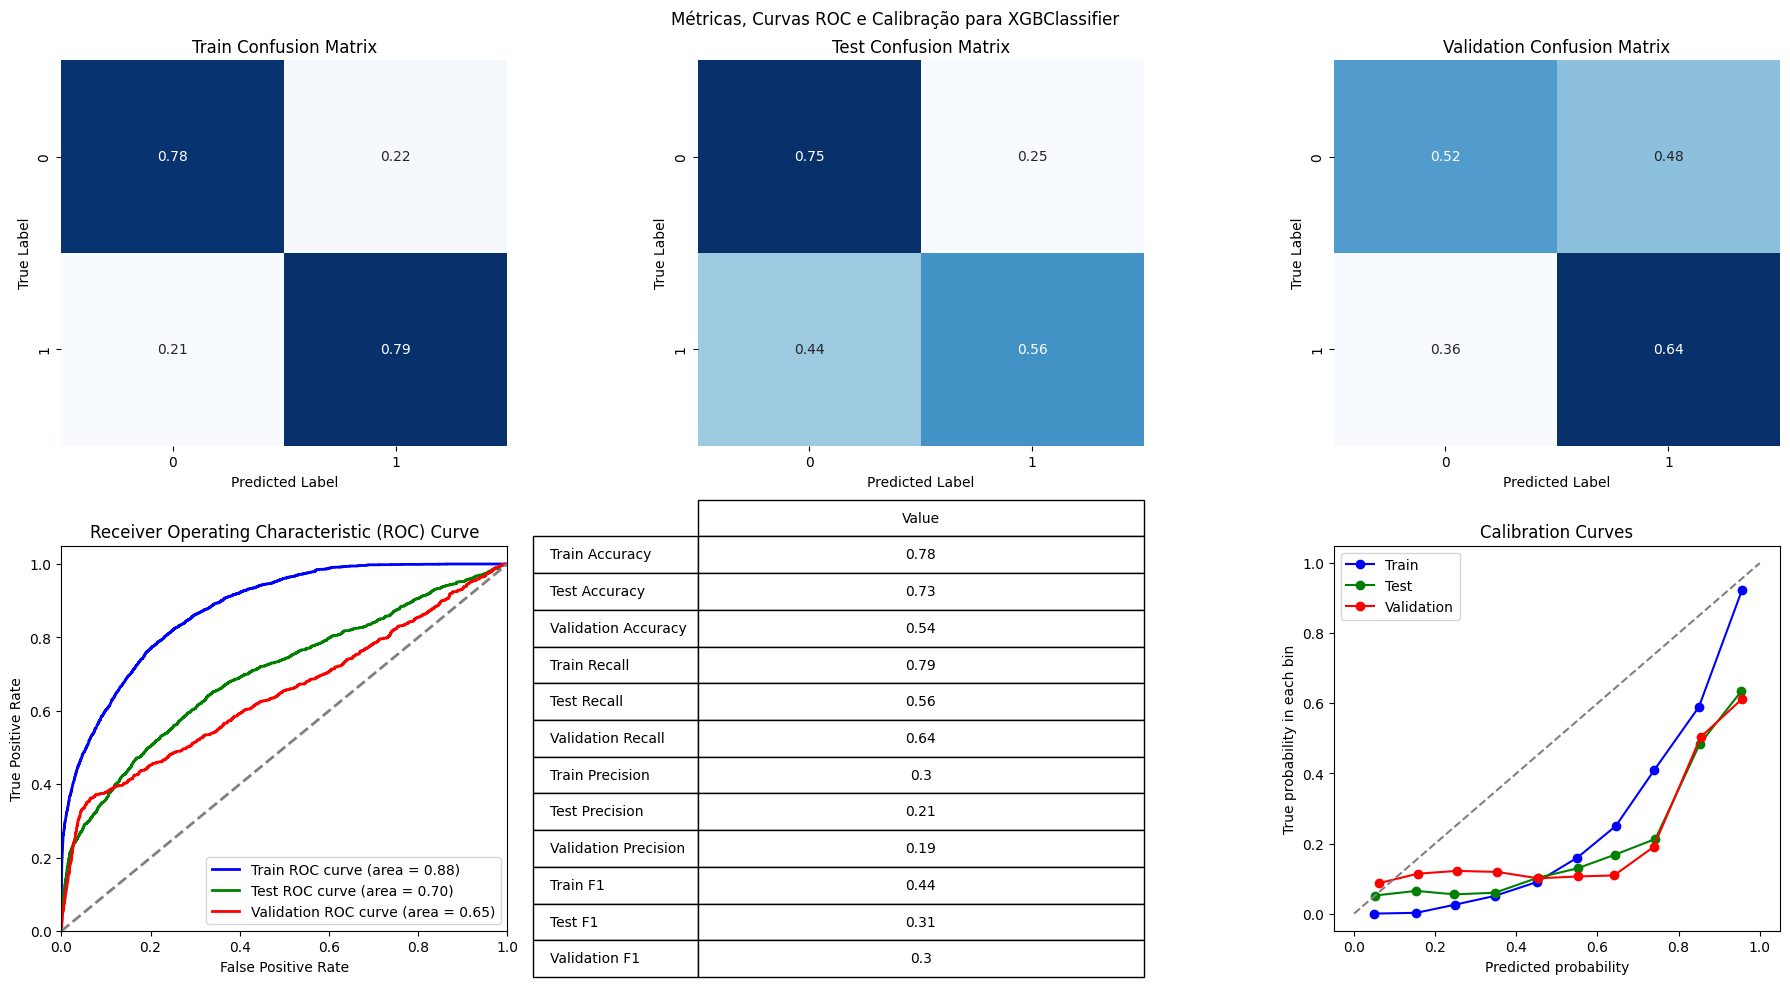

In [ ]:
plot_confusion_matrix_and_roc(model, X_train1, y_train, X_test1, y_test, X_val1, y_val)

## 4. OTIMIZAÇÃO DO MODELO

### 4.1 OTIMIZAÇÃO POR AUC

In [ ]:
xgb = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09)

#espaço de busca dos hiperparâmetros
param_distributions = {
    'n_estimators': np.arange(50, 201, 50),  # Variação do número de estimadores
    'learning_rate': np.linspace(0.01, 0.3, 10),  # Taxa de aprendizado
    'max_depth': np.arange(3, 11, 2),  # Profundidade máxima
    'min_child_weight': np.arange(1, 6, 2),
    'subsample': np.linspace(0.6, 1.0, 5),  # Subamostragem
    'colsample_bytree': np.linspace(0.6, 1.0, 5),  # Subamostragem de colunas por árvore
    'gamma': np.linspace(0, 0.5, 5)  # Parâmetro de regularização gamma

}

#métrica de avaliação
scorer = make_scorer(roc_auc_score, needs_proba=True)

#otimizador de hiperparâmetros usando RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=200,
    scoring=scorer,
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train1, y_train)

best_params = random_search.best_params_
print(f'Melhores hiperparâmetros: {best_params}')

best_model = random_search.best_estimator_

y_test_pred = best_model.predict_proba(X_test1)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred)
print(f'ROC AUC no conjunto de teste: {test_auc}')

y_val_pred = best_model.predict_proba(X_val1)[:, 1]
val_auc = roc_auc_score(y_val, y_val_pred)
print(f'ROC AUC no conjunto de validação: {val_auc}')

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Melhores hiperparâmetros: {'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.125, 'colsample_bytree': 0.6}
ROC AUC no conjunto de teste: 0.7365851025775576
ROC AUC no conjunto de validação: 0.688407028947291


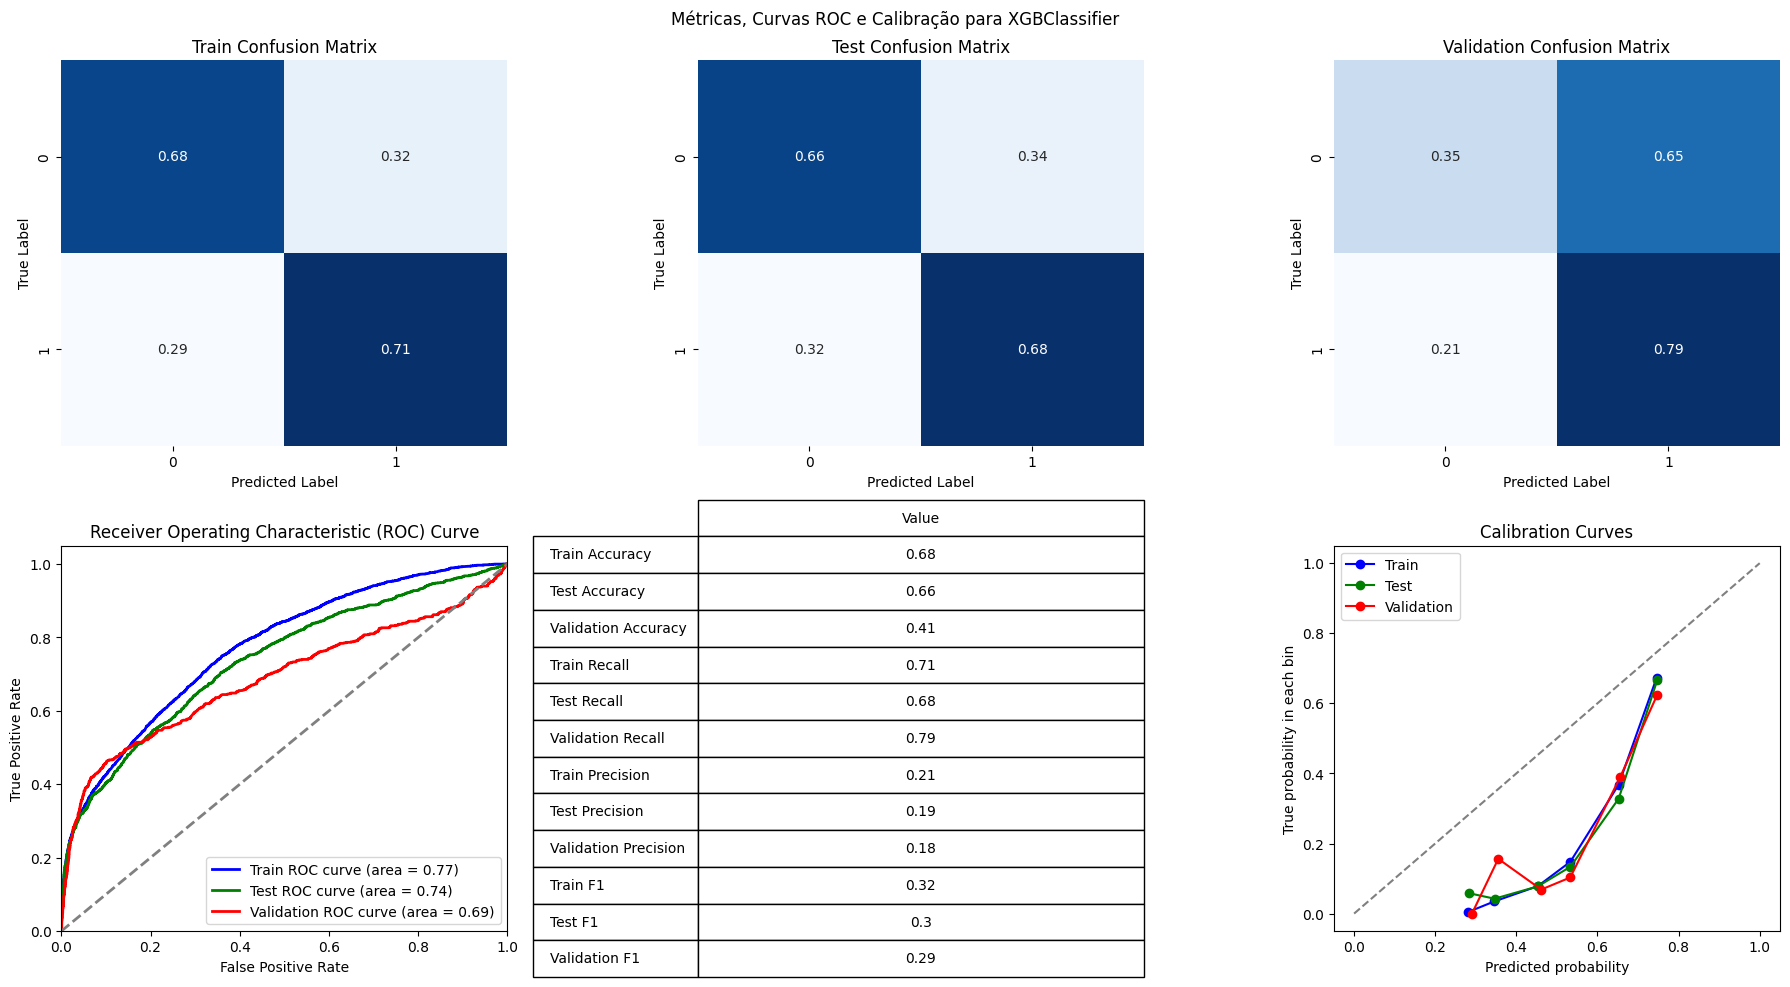

In [ ]:
model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09, **best_params)
plot_confusion_matrix_and_roc(model, X_train1, y_train, X_test1, y_test, X_val1, y_val)

In [ ]:
xgb = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09)

#espaço de busca dos hiperparâmetros
param_distributions = {
    'n_estimators': np.arange(50, 201, 50),  # Variação do número de estimadores
    'learning_rate': np.linspace(0.01, 0.3, 10),  # Taxa de aprendizado
    'max_depth': np.arange(3, 11, 2),  # Profundidade máxima
    'min_child_weight': np.arange(1, 6, 2),
    'subsample': np.linspace(0.6, 1.0, 5),  # Subamostragem
    'colsample_bytree': np.linspace(0.6, 1.0, 5),  # Subamostragem de colunas por árvore
    'gamma': np.linspace(0, 0.5, 5)  # Parâmetro de regularização gamma
}

#métrica de avaliação
scorer = make_scorer(roc_auc_score, needs_proba=True)

#otimizador de hiperparâmetros usando RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=200,
    scoring=scorer,
    cv=3,
    verbose=50,
    random_state=100,
    n_jobs=-1
)

random_search.fit(X_train1, y_train)

best_params = random_search.best_params_
print(f'Melhores hiperparâmetros: {best_params}')

best_model = random_search.best_estimator_

y_test_pred = best_model.predict_proba(X_test1)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred)
print(f'ROC AUC no conjunto de teste: {test_auc}')

y_val_pred = best_model.predict_proba(X_val1)[:, 1]
val_auc = roc_auc_score(y_val, y_val_pred)
print(f'ROC AUC no conjunto de validação: {val_auc}')

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Melhores hiperparâmetros: {'subsample': 0.8, 'n_estimators': 50, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.10666666666666666, 'gamma': 0.375, 'colsample_bytree': 0.6}
ROC AUC no conjunto de teste: 0.7390280069272746
ROC AUC no conjunto de validação: 0.6883369228545193


In [ ]:
model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09, **best_params)
plot_confusion_matrix_and_roc(model, X_train1, y_train, X_test1, y_test, X_val1, y_val)

In [ ]:
xgb = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09)

#espaço de busca dos hiperparâmetros
param_distributions = {
    'n_estimators': np.arange(50, 201, 50),  # Variação do número de estimadores
    'learning_rate': np.linspace(0.01, 0.3, 10),  # Taxa de aprendizado
    'max_depth': np.arange(3, 11, 2),  # Profundidade máxima
    'min_child_weight': np.arange(1, 6, 2),
    'subsample': np.linspace(0.6, 1.0, 5),  # Subamostragem
    'colsample_bytree': np.linspace(0.6, 1.0, 5),  # Subamostragem de colunas por árvore
    'gamma': np.linspace(0, 0.5, 5)  # Parâmetro de regularização gamma
}

#métrica de avaliação
scorer = make_scorer(roc_auc_score, needs_proba=True)

#otimizador de hiperparâmetros usando RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=200,
    scoring=scorer,
    cv=3,
    verbose=50,
    random_state=21,
    n_jobs=-1
)

random_search.fit(X_train1, y_train)

best_params = random_search.best_params_
print(f'Melhores hiperparâmetros: {best_params}')

best_model = random_search.best_estimator_

y_test_pred = best_model.predict_proba(X_test1)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred)
print(f'ROC AUC no conjunto de teste: {test_auc}')

y_val_pred = best_model.predict_proba(X_val1)[:, 1]
val_auc = roc_auc_score(y_val, y_val_pred)
print(f'ROC AUC no conjunto de validação: {val_auc}')

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Melhores hiperparâmetros: {'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.125, 'colsample_bytree': 0.6}
ROC AUC no conjunto de teste: 0.7360602254778521
ROC AUC no conjunto de validação: 0.6866542093103568


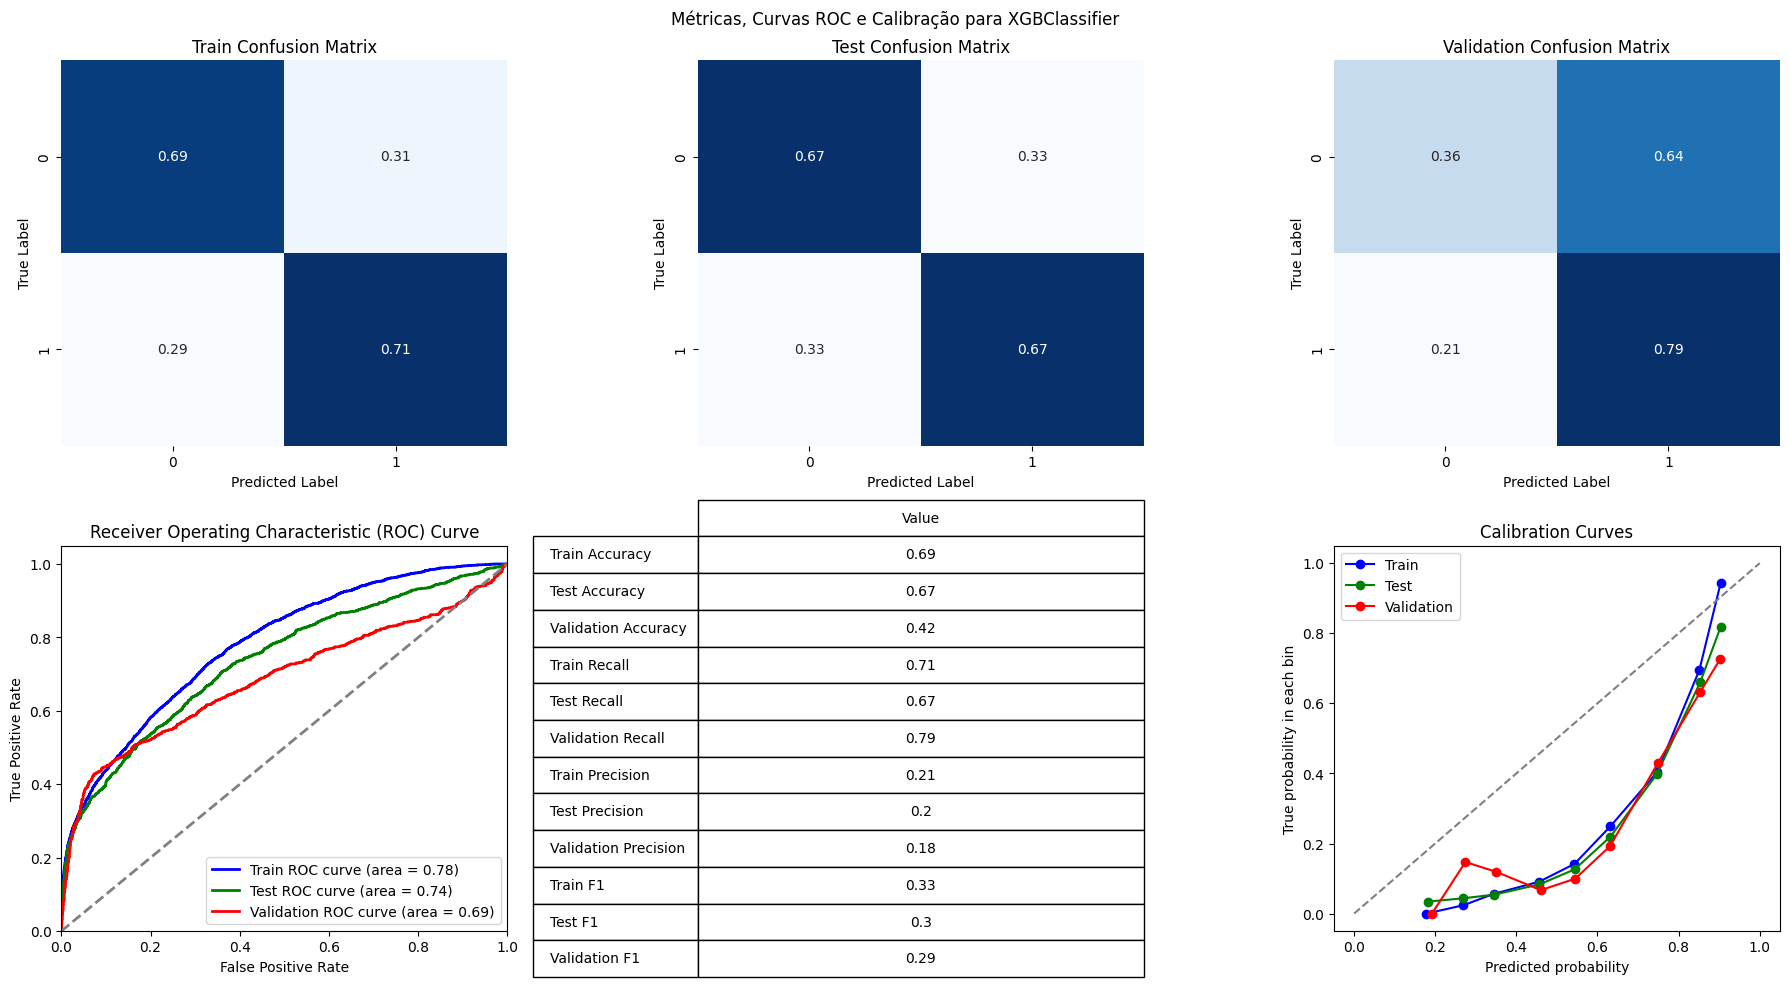

In [ ]:
model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09, **best_params)
plot_confusion_matrix_and_roc(model, X_train1, y_train, X_test1, y_test, X_val1, y_val)

### 4.2 OTIMIZAÇÃO POR F1 SCORE

In [ ]:
xgb = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09)

#espaço de busca dos hiperparâmetros
param_distributions = {
    'n_estimators': np.arange(50, 201, 50),  # Variação do número de estimadores
    'learning_rate': np.linspace(0.01, 0.3, 10),  # Taxa de aprendizado
    'max_depth': np.arange(3, 11, 2),  # Profundidade máxima
    'min_child_weight': np.arange(1, 6, 2),
    'subsample': np.linspace(0.6, 1.0, 5),  # Subamostragem
    'colsample_bytree': np.linspace(0.6, 1.0, 5),  # Subamostragem de colunas por árvore
    'gamma': np.linspace(0, 0.5, 5)  # Parâmetro de regularização gamma

}


#otimizador de hiperparâmetros usando RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=300,
    scoring='f1',
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train1, y_train)

best_params = random_search.best_params_
print(f'Melhores hiperparâmetros: {best_params}')

best_model = random_search.best_estimator_

y_test_pred = best_model.predict_proba(X_test1)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred)
print(f'ROC AUC no conjunto de teste: {test_auc}')

y_val_pred = best_model.predict_proba(X_val1)[:, 1]
val_auc = roc_auc_score(y_val, y_val_pred)
print(f'ROC AUC no conjunto de validação: {val_auc}')

Fitting 3 folds for each of 300 candidates, totalling 900 fits
Melhores hiperparâmetros: {'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.042222222222222223, 'gamma': 0.5, 'colsample_bytree': 0.7}
ROC AUC no conjunto de teste: 0.7240320874079047
ROC AUC no conjunto de validação: 0.6726846919079833


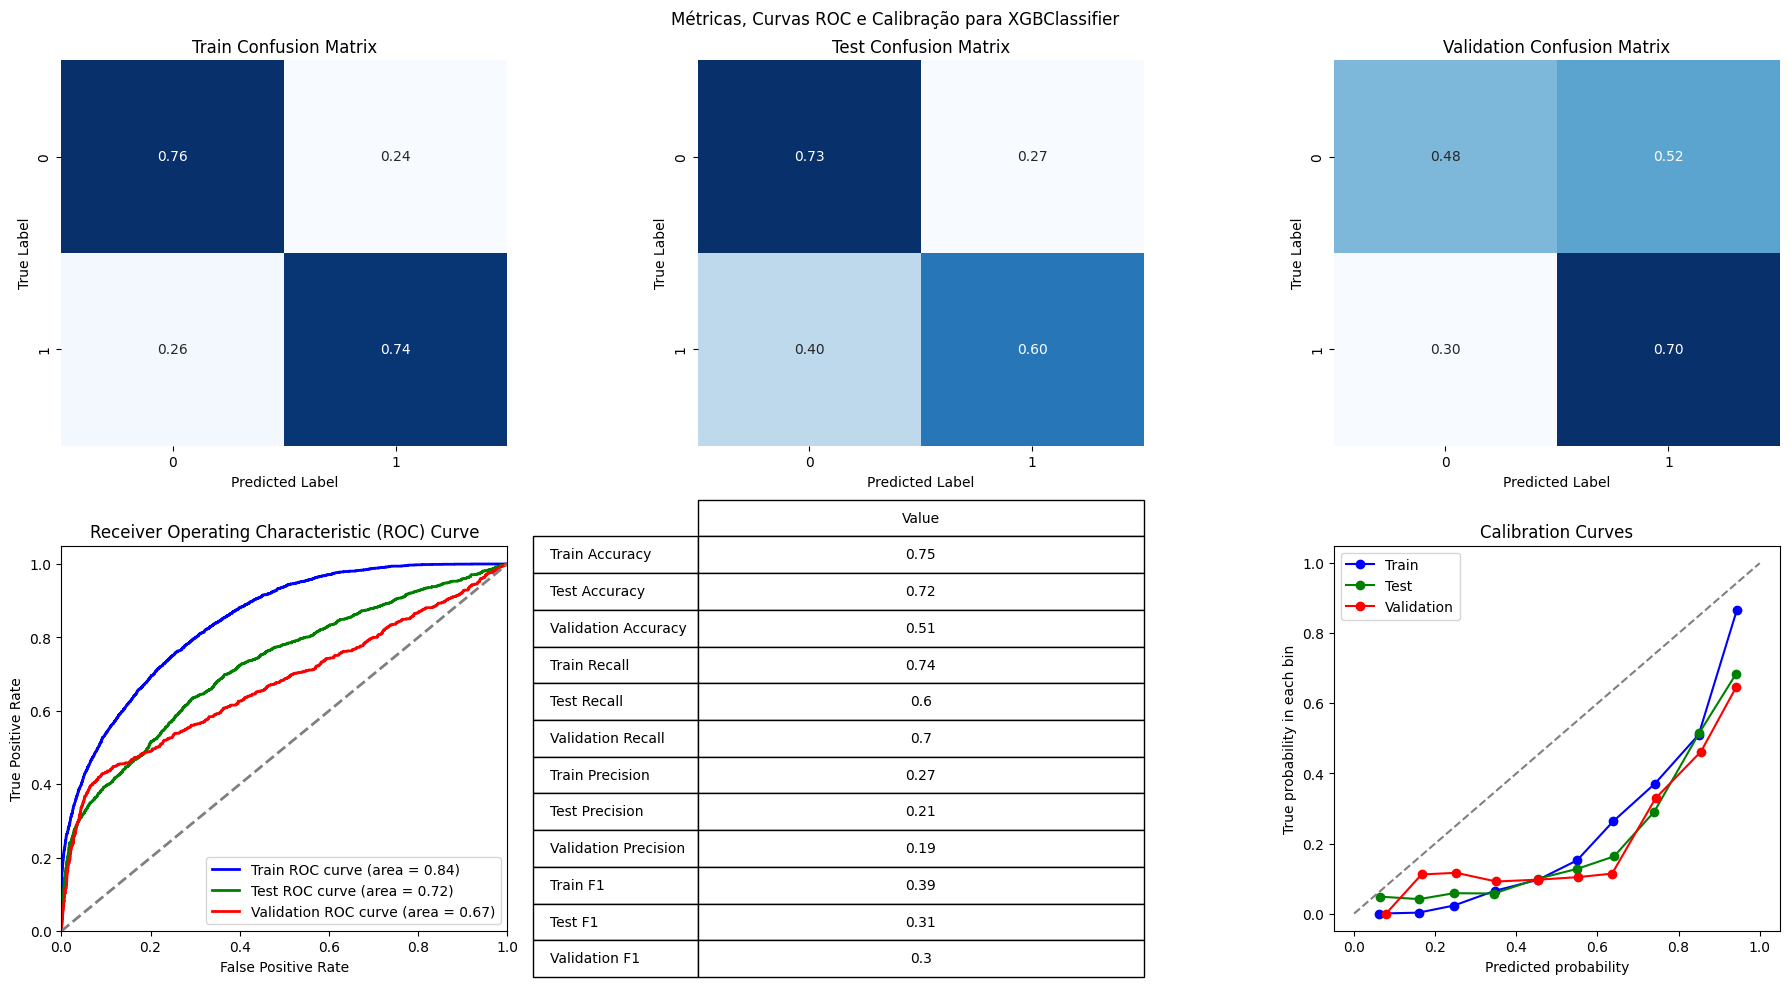

In [ ]:
model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09, **best_params)
plot_confusion_matrix_and_roc(model, X_train1, y_train, X_test1, y_test, X_val1, y_val)

In [ ]:
xgb = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09)

#espaço de busca dos hiperparâmetros
param_distributions = {
    'n_estimators': np.arange(50, 201, 50),  # Variação do número de estimadores
    'learning_rate': np.linspace(0.01, 0.3, 10),  # Taxa de aprendizado
    'max_depth': np.arange(3, 11, 2),  # Profundidade máxima
    'min_child_weight': np.arange(1, 6, 2),
    'subsample': np.linspace(0.6, 1.0, 5),  # Subamostragem
    'colsample_bytree': np.linspace(0.6, 1.0, 5),  # Subamostragem de colunas por árvore
    'gamma': np.linspace(0, 0.5, 5)  # Parâmetro de regularização gamma

}


#otimizador de hiperparâmetros usando RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=300,
    scoring='f1',
    cv=3,
    verbose=50,
    random_state=11,
    n_jobs=-1
)

random_search.fit(X_train1, y_train)

best_params = random_search.best_params_
print(f'Melhores hiperparâmetros: {best_params}')

best_model = random_search.best_estimator_

y_test_pred = best_model.predict_proba(X_test1)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred)
print(f'ROC AUC no conjunto de teste: {test_auc}')

y_val_pred = best_model.predict_proba(X_val1)[:, 1]
val_auc = roc_auc_score(y_val, y_val_pred)
print(f'ROC AUC no conjunto de validação: {val_auc}')

Fitting 3 folds for each of 300 candidates, totalling 900 fits
Melhores hiperparâmetros: {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.07444444444444444, 'gamma': 0.0, 'colsample_bytree': 0.9}
ROC AUC no conjunto de teste: 0.7169466186288781
ROC AUC no conjunto de validação: 0.6704202149161671


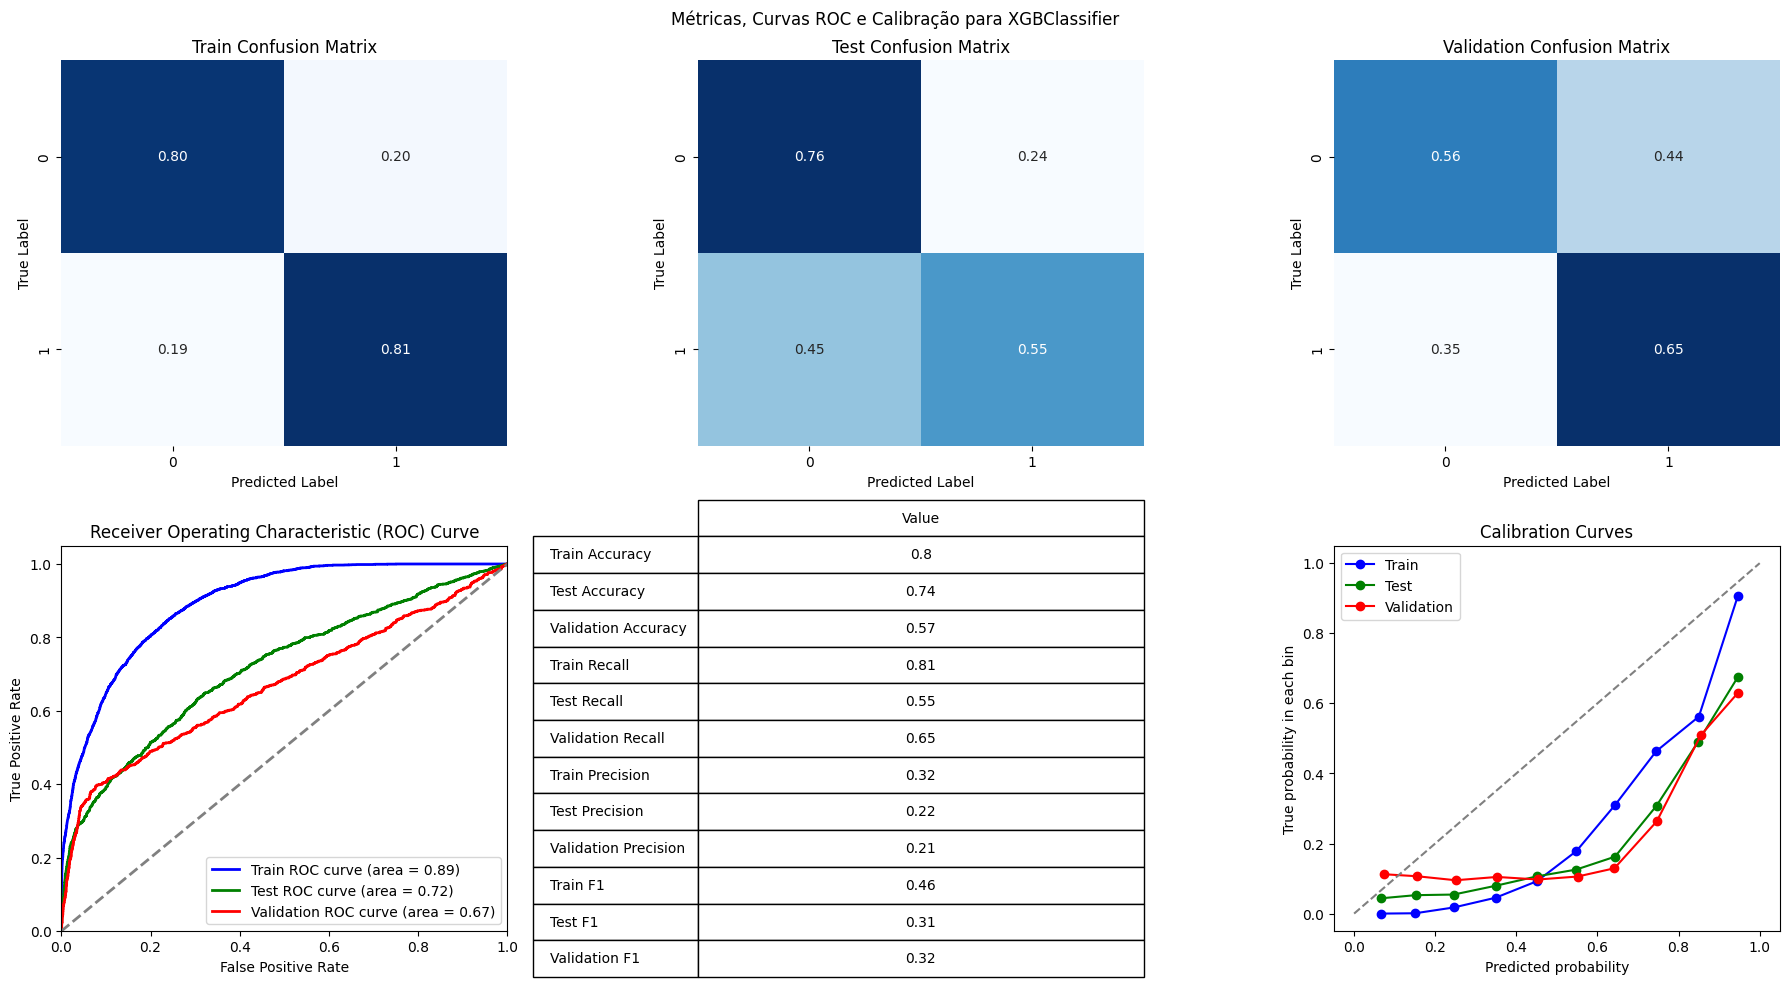

In [ ]:
model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09, **best_params)
plot_confusion_matrix_and_roc(model, X_train1, y_train, X_test1, y_test, X_val1, y_val)

In [ ]:
xgb = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09)

#espaço de busca dos hiperparâmetros
param_distributions = {
    'n_estimators': np.arange(50, 201, 50),  # Variação do número de estimadores
    'learning_rate': np.linspace(0.01, 0.3, 10),  # Taxa de aprendizado
    'max_depth': np.arange(3, 11, 2),  # Profundidade máxima
    'min_child_weight': np.arange(1, 6, 2),
    'subsample': np.linspace(0.6, 1.0, 5),  # Subamostragem
    'colsample_bytree': np.linspace(0.6, 1.0, 5),  # Subamostragem de colunas por árvore
    'gamma': np.linspace(0, 0.5, 5)  # Parâmetro de regularização gamma

}


#otimizador de hiperparâmetros usando RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=300,
    scoring='f1',
    cv=3,
    verbose=50,
    random_state=22,
    n_jobs=-1
)

random_search.fit(X_train1, y_train)

best_params = random_search.best_params_
print(f'Melhores hiperparâmetros: {best_params}')

best_model = random_search.best_estimator_

y_test_pred = best_model.predict_proba(X_test1)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred)
print(f'ROC AUC no conjunto de teste: {test_auc}')

y_val_pred = best_model.predict_proba(X_val1)[:, 1]
val_auc = roc_auc_score(y_val, y_val_pred)
print(f'ROC AUC no conjunto de validação: {val_auc}')

Fitting 3 folds for each of 300 candidates, totalling 900 fits
Melhores hiperparâmetros: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.042222222222222223, 'gamma': 0.0, 'colsample_bytree': 0.6}
ROC AUC no conjunto de teste: 0.7276373290527243
ROC AUC no conjunto de validação: 0.6734054963176733


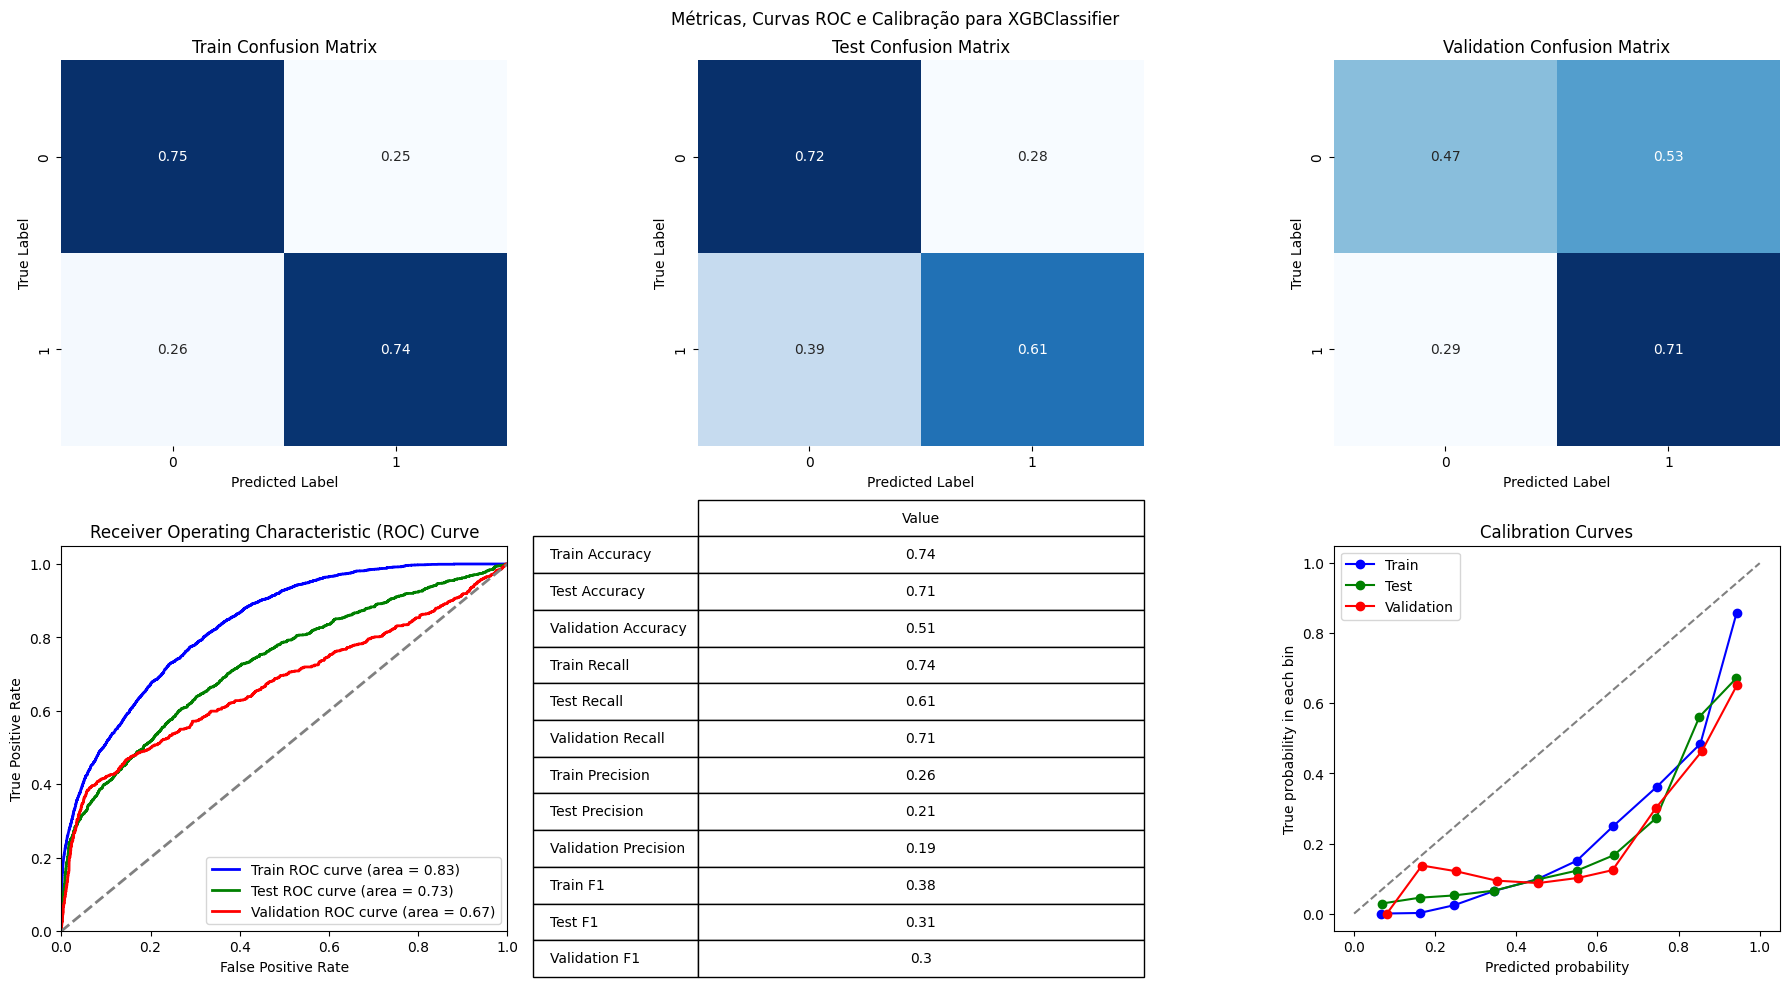

In [ ]:
model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09, **best_params)
plot_confusion_matrix_and_roc(model, X_train1, y_train, X_test1, y_test, X_val1, y_val)

### 4.3 OTIMIZAÇÃO POR F1 SCORE WEIGHTED

In [ ]:
xgb = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09)

#espaço de busca dos hiperparâmetros
param_distributions = {
    'n_estimators': np.arange(50, 201, 50),  # Variação do número de estimadores
    'learning_rate': np.linspace(0.01, 0.3, 10),  # Taxa de aprendizado
    'max_depth': np.arange(3, 11, 2),  # Profundidade máxima
    'min_child_weight': np.arange(1, 6, 2),
    'subsample': np.linspace(0.6, 1.0, 5),  # Subamostragem
    'colsample_bytree': np.linspace(0.6, 1.0, 5),  # Subamostragem de colunas por árvore
    'gamma': np.linspace(0, 0.5, 5)  # Parâmetro de regularização gamma

}


#otimizador de hiperparâmetros usando RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=300,
    scoring='f1_weighted',
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train1, y_train)

best_params = random_search.best_params_
print(f'Melhores hiperparâmetros: {best_params}')

best_model = random_search.best_estimator_

y_test_pred = best_model.predict_proba(X_test1)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred)
print(f'ROC AUC no conjunto de teste: {test_auc}')

y_val_pred = best_model.predict_proba(X_val1)[:, 1]
val_auc = roc_auc_score(y_val, y_val_pred)
print(f'ROC AUC no conjunto de validação: {val_auc}')

Fitting 3 folds for each of 300 candidates, totalling 900 fits
Melhores hiperparâmetros: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0.125, 'colsample_bytree': 0.9}
ROC AUC no conjunto de teste: 0.6678707630104825
ROC AUC no conjunto de validação: 0.6376590856157691


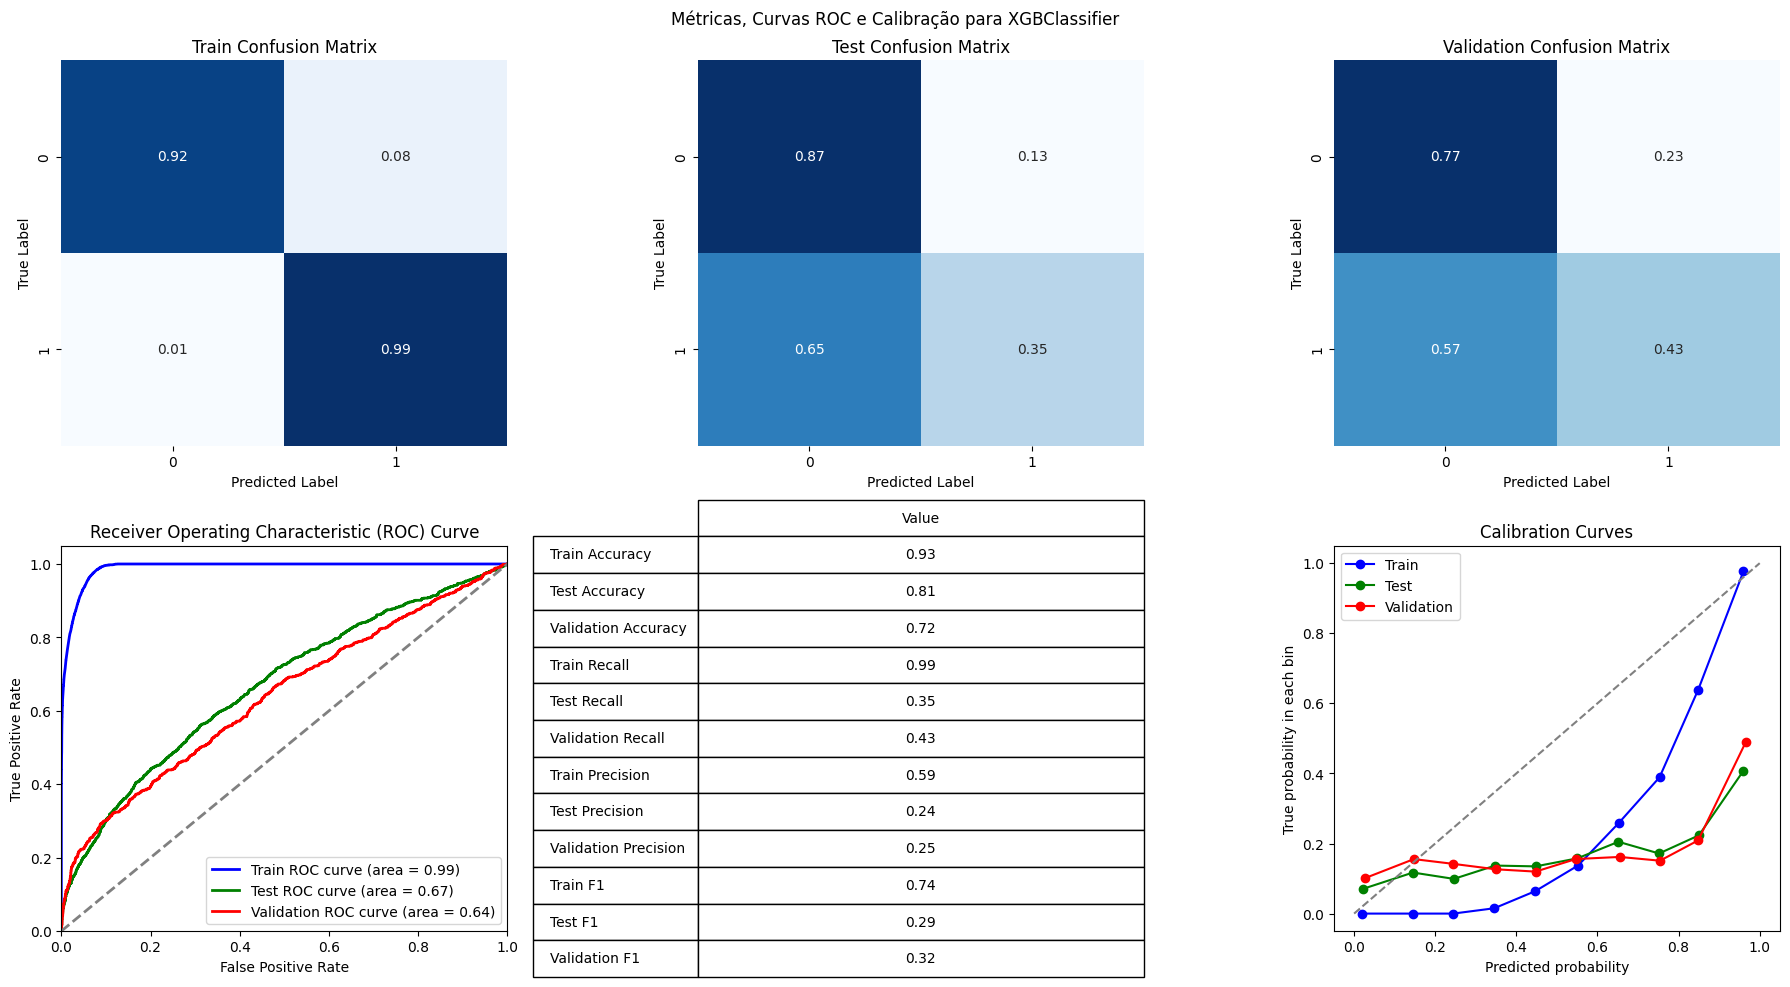

In [ ]:
model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09, **best_params)
plot_confusion_matrix_and_roc(model, X_train1, y_train, X_test1, y_test, X_val1, y_val)

### 4.4 OTIMIZAÇÃO POR RECALL

In [ ]:
xgb = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09)

#espaço de busca dos hiperparâmetros
param_distributions = {
    'n_estimators': np.arange(50, 201, 50),  # Variação do número de estimadores
    'learning_rate': np.linspace(0.01, 0.3, 10),  # Taxa de aprendizado
    'max_depth': np.arange(3, 11, 2),  # Profundidade máxima
    'min_child_weight': np.arange(1, 6, 2),
    'subsample': np.linspace(0.6, 1.0, 5),  # Subamostragem
    'colsample_bytree': np.linspace(0.6, 1.0, 5),  # Subamostragem de colunas por árvore
    'gamma': np.linspace(0, 0.5, 5)  # Parâmetro de regularização gamma

}


#otimizador de hiperparâmetros usando RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=300,
    scoring='recall',
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train1, y_train)

best_params = random_search.best_params_
print(f'Melhores hiperparâmetros: {best_params}')

best_model = random_search.best_estimator_

y_test_pred = best_model.predict_proba(X_test1)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred)
print(f'ROC AUC no conjunto de teste: {test_auc}')

y_val_pred = best_model.predict_proba(X_val1)[:, 1]
val_auc = roc_auc_score(y_val, y_val_pred)
print(f'ROC AUC no conjunto de validação: {val_auc}')

Fitting 3 folds for each of 300 candidates, totalling 900 fits
Melhores hiperparâmetros: {'subsample': 0.9, 'n_estimators': 150, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.0, 'colsample_bytree': 1.0}
ROC AUC no conjunto de teste: 0.7287747159728099
ROC AUC no conjunto de validação: 0.6759602694215628


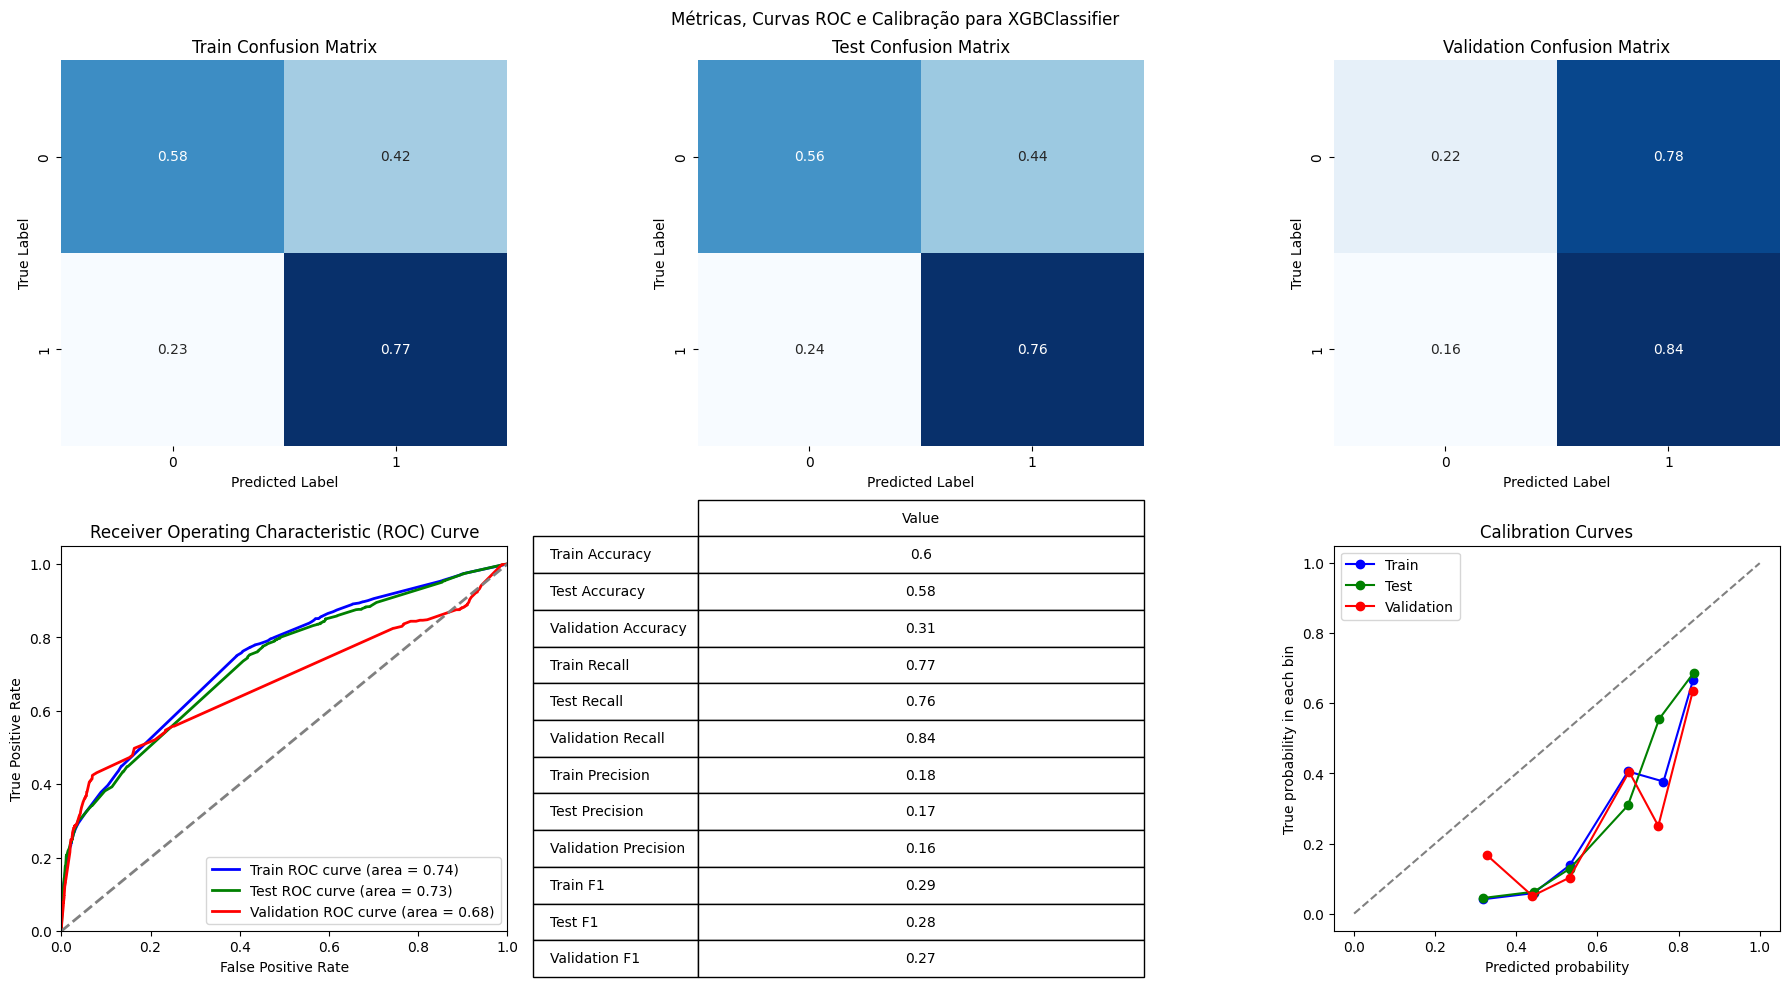

In [ ]:
model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09, **best_params)
plot_confusion_matrix_and_roc(model, X_train1, y_train, X_test1, y_test, X_val1, y_val)

### 4.5 RESULTADO DA OTIMIZAÇÃO


O segundo cenário da otimização por F1 Score parece ser o melhor balanço entre as diferentes métricas. Ele possui uma boa acurácia e recall tanto nos conjuntos de teste quanto de validação, e a área sob a curva ROC é consistente entre os conjuntos de dados, indicando boa capacidade de generalização do modelo.

Melhores hiperparâmetros: {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.07444444444444444, 'gamma': 0.0, 'colsample_bytree': 0.9}


## 5. ANÁLISE DO MODELO SELECIONADO

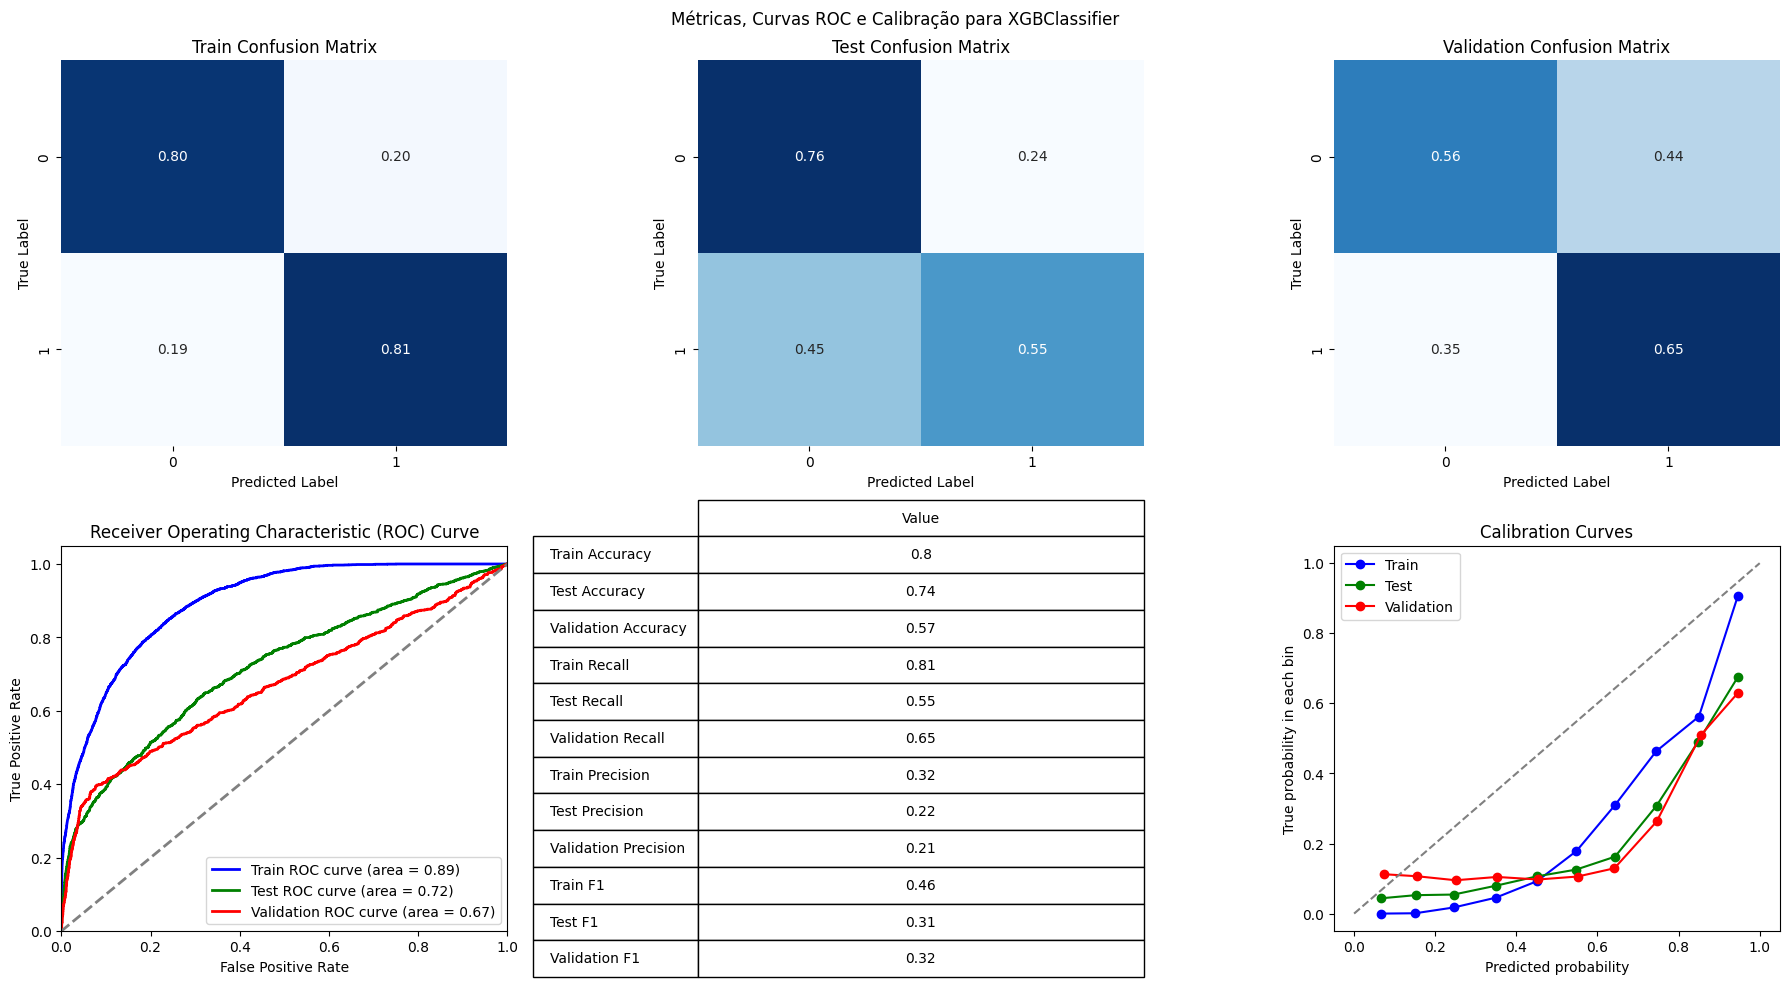

In [ ]:
best_params = {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.07444444444444444, 'gamma': 0.0, 'colsample_bytree': 0.9}
model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09, **best_params)
plot_confusion_matrix_and_roc(model, X_train1, y_train, X_test1, y_test, X_val1, y_val)

### 5.1 CALIBRAÇÃO DE PROBABILIDADES

In [ ]:
#calibrando modelo
calibrated_xgb = CalibratedClassifierCV(model, method='sigmoid', cv=5)
calibrated_xgb.fit(X_train1, y_train)

calibrated_xgb_isotonic = CalibratedClassifierCV(model, method='isotonic', cv=5)
calibrated_xgb_isotonic.fit(X_train1, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=0.9,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=0.0,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.07444444444444444,
                                               max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=9,
                                               max_leaves=None,
                                               min_child_weight=3, missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=100, n_jobs=-1,
                                               num_parallel_tree=None,
                                               random_state=42, ...),
                       method='isotonic')

In [ ]:
y_prob_xgb = model.predict_proba(X_test1)[:, 1]
y_prob_calibrated_xgb = calibrated_xgb.predict_proba(X_test1)[:, 1]
y_prob_calibrated_xgb_isotonic = calibrated_xgb_isotonic.predict_proba(X_test1)[:, 1]

In [ ]:
bins = 10
prob_true_xgb, prob_pred_xgb = calibration_curve(y_test, y_prob_xgb, n_bins=bins)
prob_true_cal_xgb, prob_pred_cal_xgb = calibration_curve(y_test, y_prob_calibrated_xgb, n_bins=bins)
prob_true_cal_xgb_isotonic, prob_pred_cal_xgb_isotonic = calibration_curve(y_test, y_prob_calibrated_xgb_isotonic, n_bins=bins)

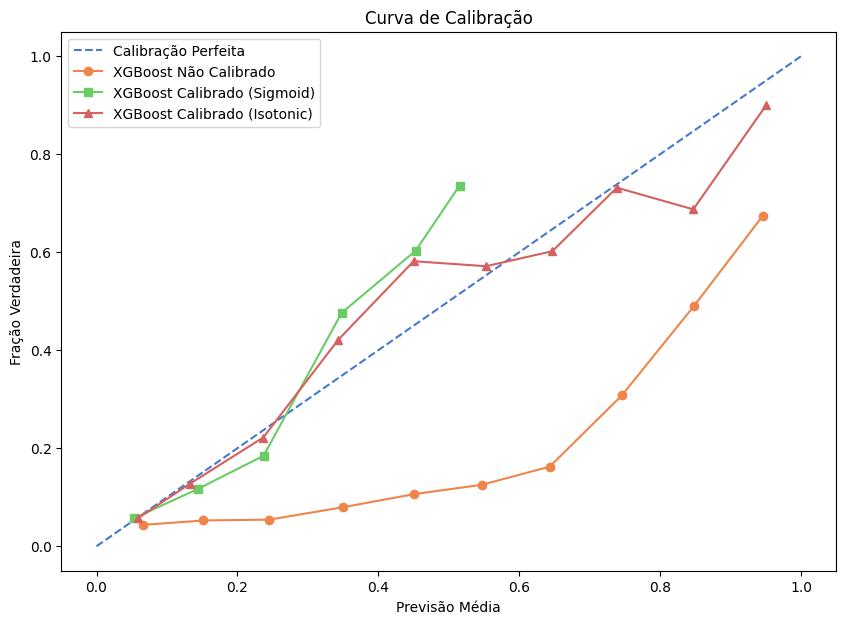

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], linestyle='--', label='Calibração Perfeita')
plt.plot(prob_pred_xgb, prob_true_xgb, marker='o', label='XGBoost Não Calibrado')
plt.plot(prob_pred_cal_xgb, prob_true_cal_xgb, marker='s', label='XGBoost Calibrado (Sigmoid)')
plt.plot(prob_pred_cal_xgb_isotonic, prob_true_cal_xgb_isotonic, marker='^', label='XGBoost Calibrado (Isotonic)')
plt.xlabel('Previsão Média')
plt.ylabel('Fração Verdadeira')
plt.title('Curva de Calibração')
plt.legend()
plt.show()

Modelos baseados em árvores de decisão, como o XGBoost, geralmente são mais difíceis de calibrar em comparação com modelos lineares.

A análise das curvas de calibração mostra que:

- **XGBoost Não Calibrado**: Apresenta uma calibração pobre, com previsões tendendo a subestimar as probabilidades verdadeiras, especialmente nas previsões médias mais altas. As previsões não seguem a linha de calibração perfeita, indicando que o modelo não calibrado tem dificuldade em fornecer probabilidades precisas.
- **XGBoost Calibrado (Sigmoid)**: Melhora a calibração em relação ao não calibrado, especialmente nas faixas intermediárias de previsão média. Contudo, ainda há algumas discrepâncias, especialmente nas previsões mais altas.
- **XGBoost Calibrado (Isotonic)**: O modelo calibrado com a regressão isotônica oferece a melhor calibração entre os três modelos mostrados. A linha vermelha está mais próxima da linha de calibração perfeita em uma ampla faixa de previsões, sugerindo que a calibração isotônica consegue ajustar melhor as probabilidades previstas às frequências reais.

Com isso, para maximizar a calibração do modelo, optaremos pelo XGBoost calibrado com o método Isotonic. Esta escolha oferece uma melhoria significativa na calibração em comparação com o modelo não calibrado, ao mesmo tempo em que mantém uma estabilidade consistente nas previsões em todas as faixas.

### 5.2 FEATURE IMPORTANCE

In [ ]:
feature_importances = model.feature_importances_
relative_importances = feature_importances / feature_importances.sum()

features = X_train1.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': relative_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
display(importance_df)

Feature  Importance
6               pdays    0.144493
25   poutcome_success    0.143221
22   contact_cellular    0.120738
16        job_student    0.043844
2             default    0.043677
14  job_self-employed    0.029100
18     job_unemployed    0.028562
9     job_blue-collar    0.027422
15       job_services    0.027270
12     job_management    0.027090
10   job_entrepreneur    0.026498
0                 age    0.026337
11      job_housemaid    0.026256
19   marital_divorced    0.025239
21     marital_single    0.024611
5            campaign    0.024260
17     job_technician    0.023207
13        job_retired    0.022862
1           education    0.022472
4                loan    0.021826
20    marital_married    0.021031
8          job_admin.    0.020603
24   poutcome_failure    0.020306
3             housing    0.019950
7            previous    0.019879
23  contact_telephone    0.019245

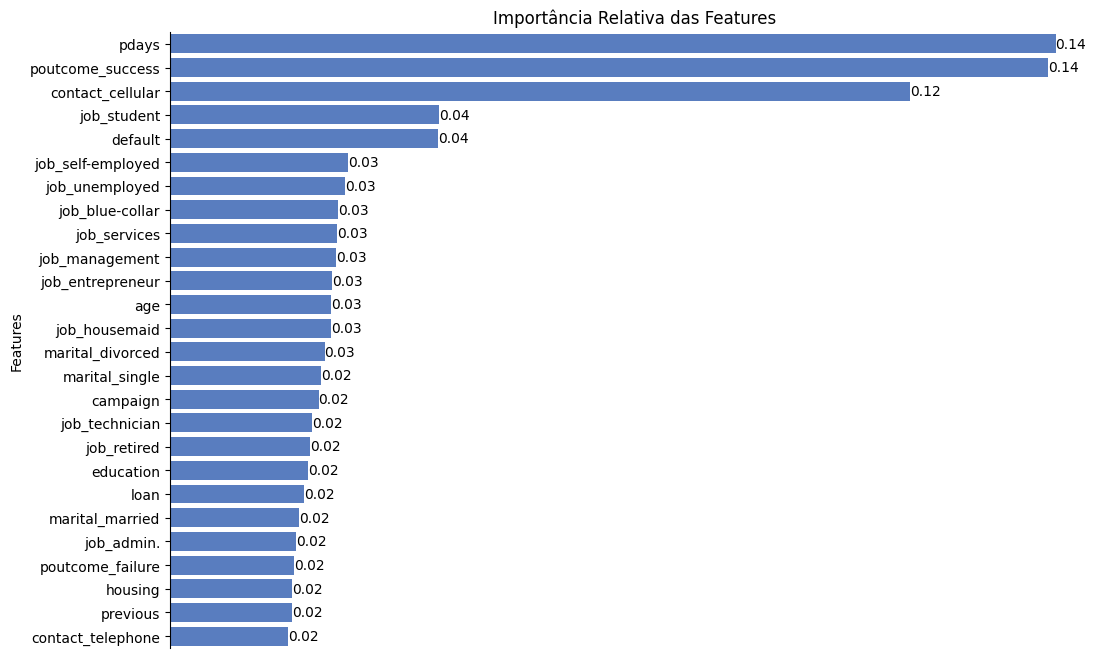

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)

# Adicionando os valores dentro das barras
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.2f}', va='center')

plt.title('Importância Relativa das Features')
plt.xlabel('Importância Relativa')
plt.ylabel('Features')
plt.gca().get_xaxis().set_visible(False)
sns.despine(left=False, bottom=True)
plt.show()

A análise da importância relativa das features no modelo XGBoost revela alguns insights importantes:

- **pdays e poutcome_success** são as features mais importantes, ambas com uma importância relativa de 0.14.
  - **pdays**: Representa o número de dias que se passaram desde que o cliente foi contatado pela última vez. Uma alta importância sugere que quanto mais recente o contato, maior a probabilidade de sucesso na campanha.
  - **poutcome_success**: Indica o resultado da campanha de marketing anterior. Se o cliente teve sucesso em campanhas anteriores, isso aumenta a chance de sucesso atual.

- **contact_cellular**: Com uma importância relativa de 0.12, esta feature sugere que a forma de contato é um fator significativo. Contatos feitos via celular têm uma probabilidade maior de sucesso.

- **job_student e default**: Ambas com uma importância relativa de 0.04.
  - **job_student**: A ocupação do cliente é um fator relevante, e estudantes podem ter comportamentos distintos em relação ao produto ou serviço oferecido.
  - **default**: Indica se o cliente está em default (inadimplente). Embora não tenha uma importância tão alta quanto as principais features, ainda é relevante.

Outras features com importância relativa de 0.03 incluem várias ocupações (**job_self-employed, job_unemployed, job_blue-collar, job_services, job_management, job_entrepreneur, job_housemaid**), estado civil (**marital_divorced**), e **age** (idade). Isso indica que, embora essas features sejam menos importantes que as principais, ainda possuem influência no desempenho do modelo.

Features como **campaign, education, loan**, e várias outras têm uma importância relativa de 0.02. Isso sugere que, embora essas variáveis tenham algum impacto, seu efeito no modelo é menos pronunciado.


A importância relativa das features fornece uma visão clara sobre quais variáveis têm maior influência no sucesso da campanha de marketing. Fatores como o número de dias desde o último contato, o sucesso em campanhas anteriores e o método de contato são os mais determinantes. Essas informações podem ajudar na segmentação de clientes e na otimização de futuras campanhas, concentrando-se nos fatores que mais impactam o sucesso.

### 5.3 LEADS VS CLIENTES

Para finalizar essa análise inicial, veremos o desempenho do modelo treinado para os clientes (previamente contactados em outras campanhas) e os leads (primeira campanha).

#### 5.3.1 CLIENTES

In [ ]:
##df_train = df_train[(df_train['poutcome_success'] == True) | (df_train['poutcome_failure'] == True)]
df_test1 = df_test[(df_test['poutcome_success'] == True) | (df_test['poutcome_failure'] == True)]
df_val1 = df_val[(df_val['poutcome_success'] == True) | (df_val['poutcome_failure'] == True)]

In [ ]:
X_traincli = df_train[indep_columns1]
X_testcli = df_test1[indep_columns1]
X_valcli = df_val1[indep_columns1]

y_train = df_train[dep_column]
y_test = df_test1[dep_column]
y_val = df_val1[dep_column]

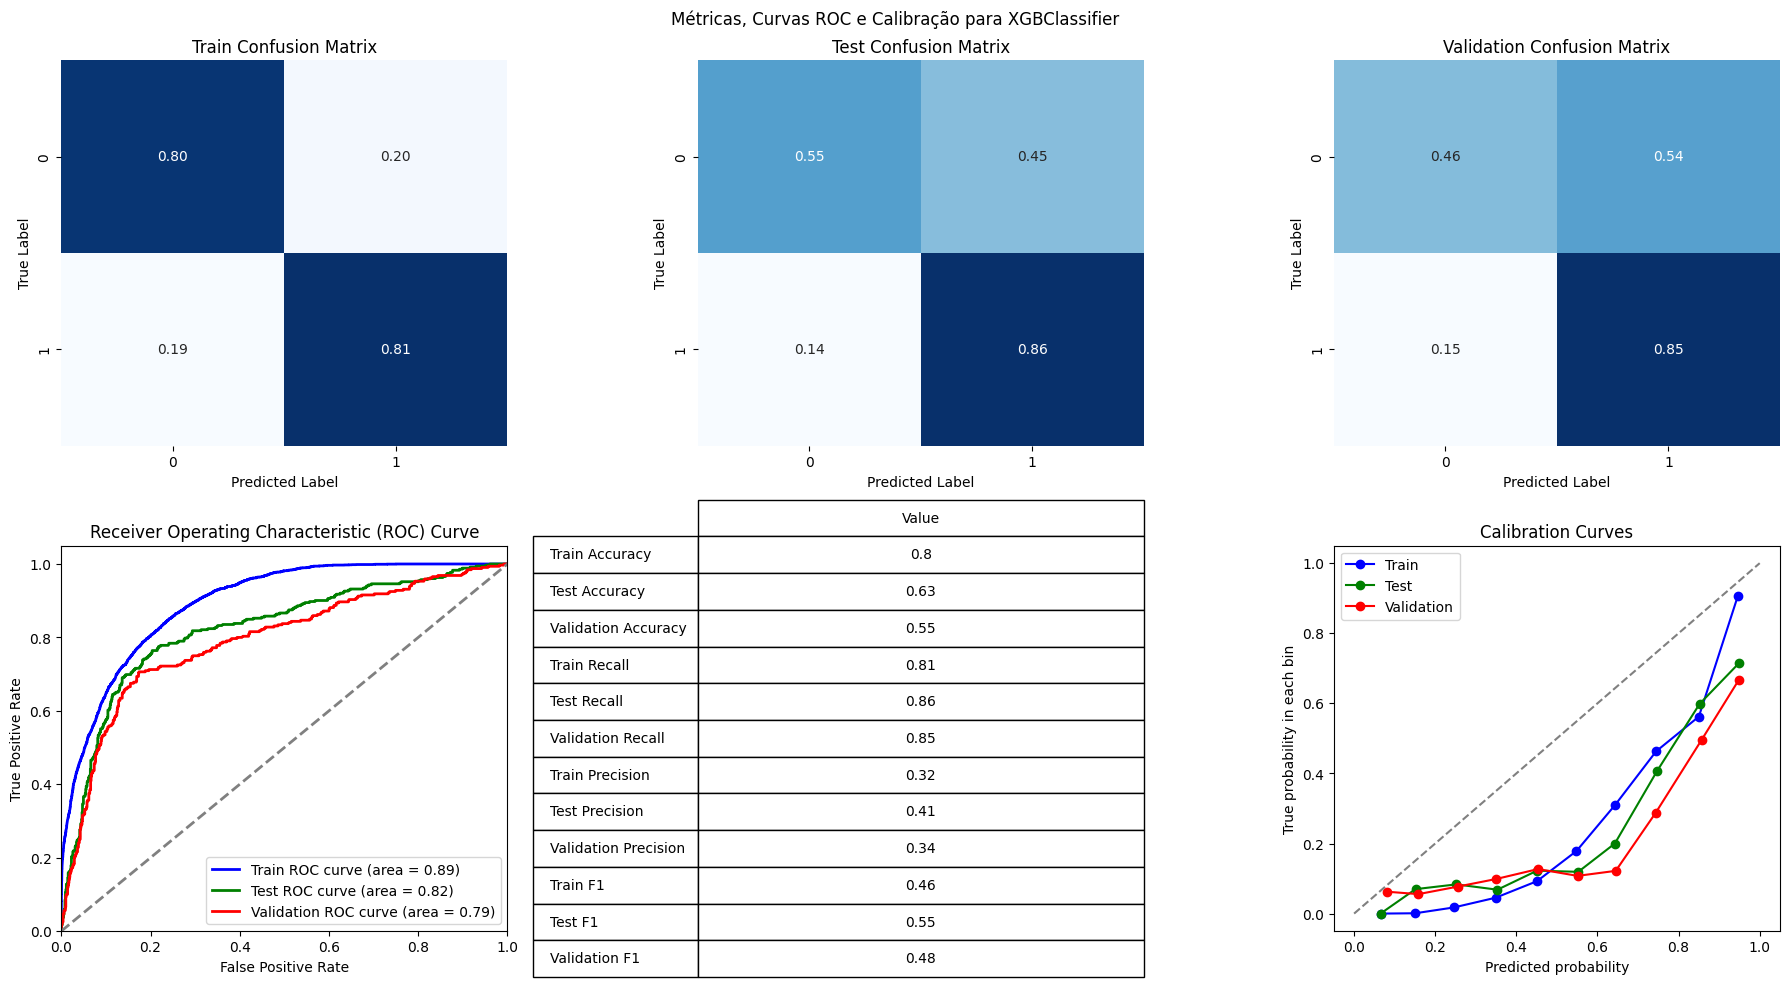

In [ ]:
#CLIENTES
best_params = {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.07444444444444444, 'gamma': 0.0, 'colsample_bytree': 0.9}
model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09, **best_params)

plot_confusion_matrix_and_roc(model, X_traincli, y_train, X_testcli, y_test, X_valcli, y_val)

#### 5.3.2 LEADS

In [ ]:
##df_train = df_train[(df_train['poutcome_success'] == False) & (df_train['poutcome_failure'] == False)]
df_test1 = df_test[(df_test['poutcome_success'] == False) & (df_test['poutcome_failure'] == False)]
df_val1 = df_val[(df_val['poutcome_success'] == False) & (df_val['poutcome_failure'] == False)]

In [ ]:
X_trainlead = df_train[indep_columns1]
X_testlead = df_test1[indep_columns1]
X_vallead = df_val1[indep_columns1]

y_train = df_train[dep_column]
y_test = df_test1[dep_column]
y_val = df_val1[dep_column]

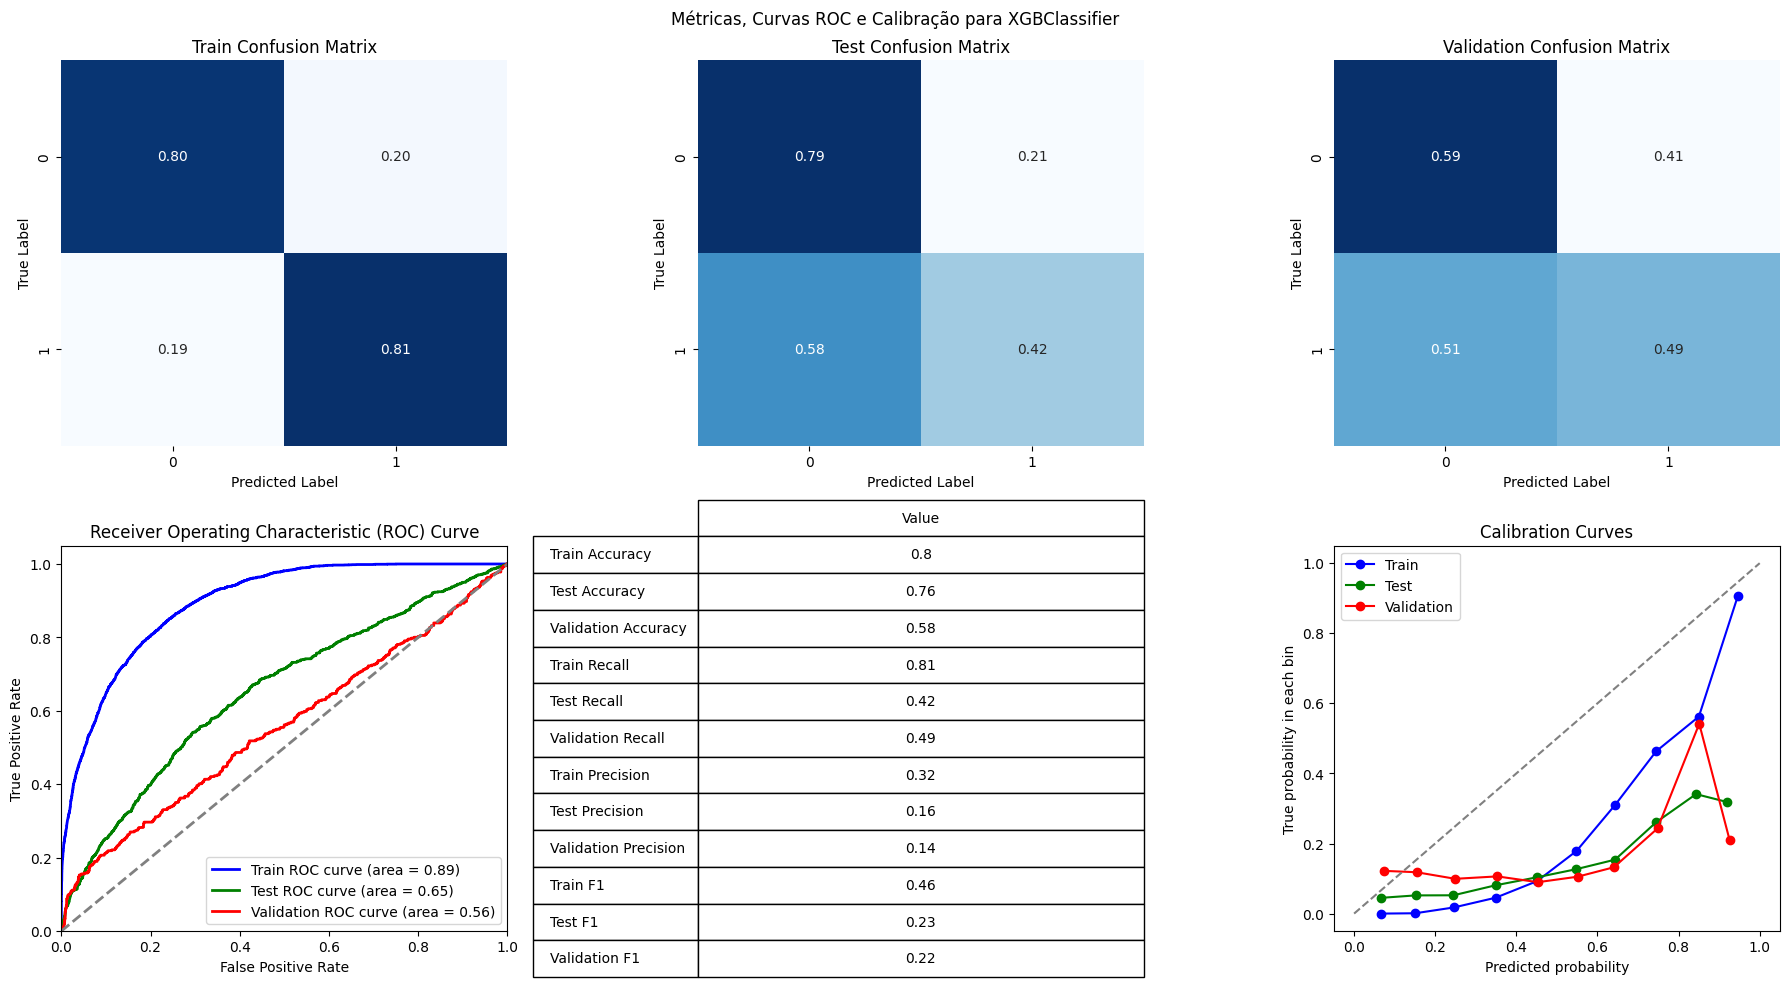

In [ ]:
#LEADS
best_params = {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.07444444444444444, 'gamma': 0.0, 'colsample_bytree': 0.9}
model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09, **best_params)

plot_confusion_matrix_and_roc(model, X_trainlead, y_train, X_testlead, y_test, X_vallead, y_val)

O modelo demonstra uma falta de capacidade de generalização, superestimando os casos de clientes e subestimando os leads.

## 6. MELHORIAS NO MODELO SELECIONADO

### 6.1 REMOVENDO FEATURES MENOS IMPORTANTES

Vamos tentar melhorar a predição do modelo removendo features menos relevantes, pois isso pode reduzir o ruído nos dados e aumentar a precisão do modelo. A simplificação do modelo pode melhorar a capacidade de generalização e desempenho.

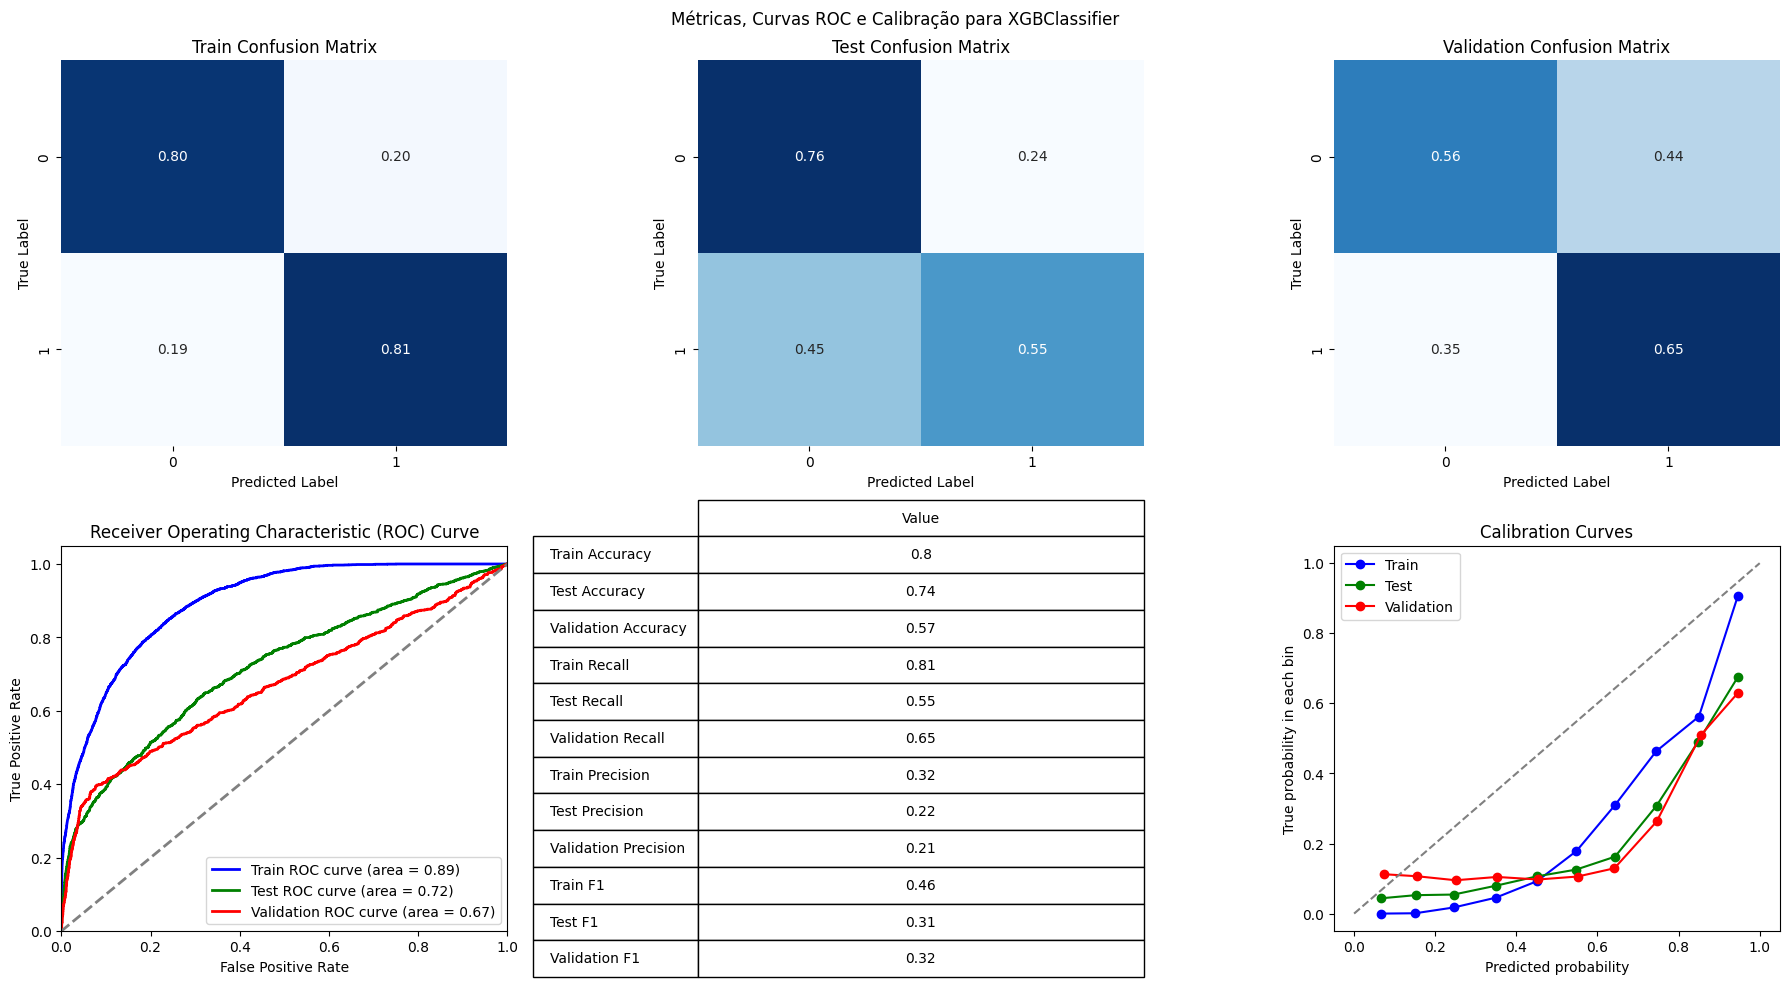

In [ ]:
best_params = {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.07444444444444444, 'gamma': 0.0, 'colsample_bytree': 0.9}
model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09, **best_params)
plot_confusion_matrix_and_roc(model, X_train1, y_train, X_test1, y_test, X_val1, y_val)

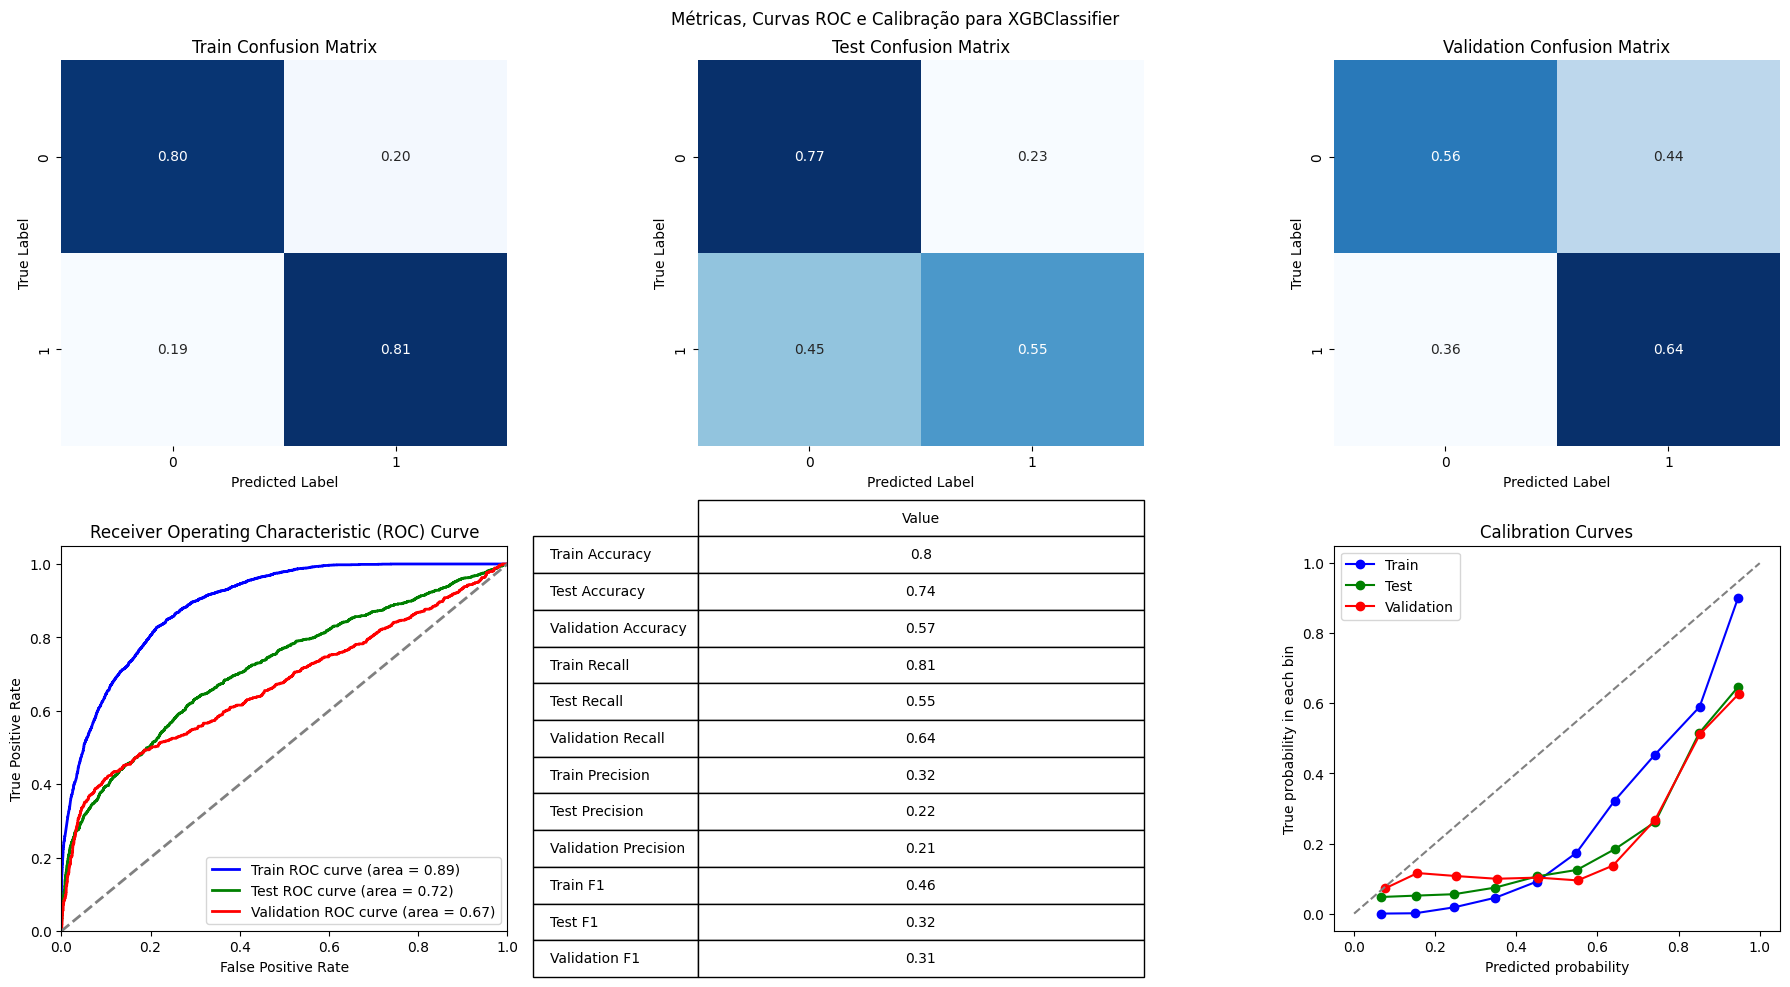

In [ ]:
X_train1a = X_train1.drop(columns=['contact_telephone'])
X_test1a = X_test1.drop(columns=['contact_telephone'])
X_val1a = X_val1.drop(columns=['contact_telephone'])

model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09, **best_params)
plot_confusion_matrix_and_roc(model, X_train1a, y_train, X_test1a, y_test, X_val1a, y_val)

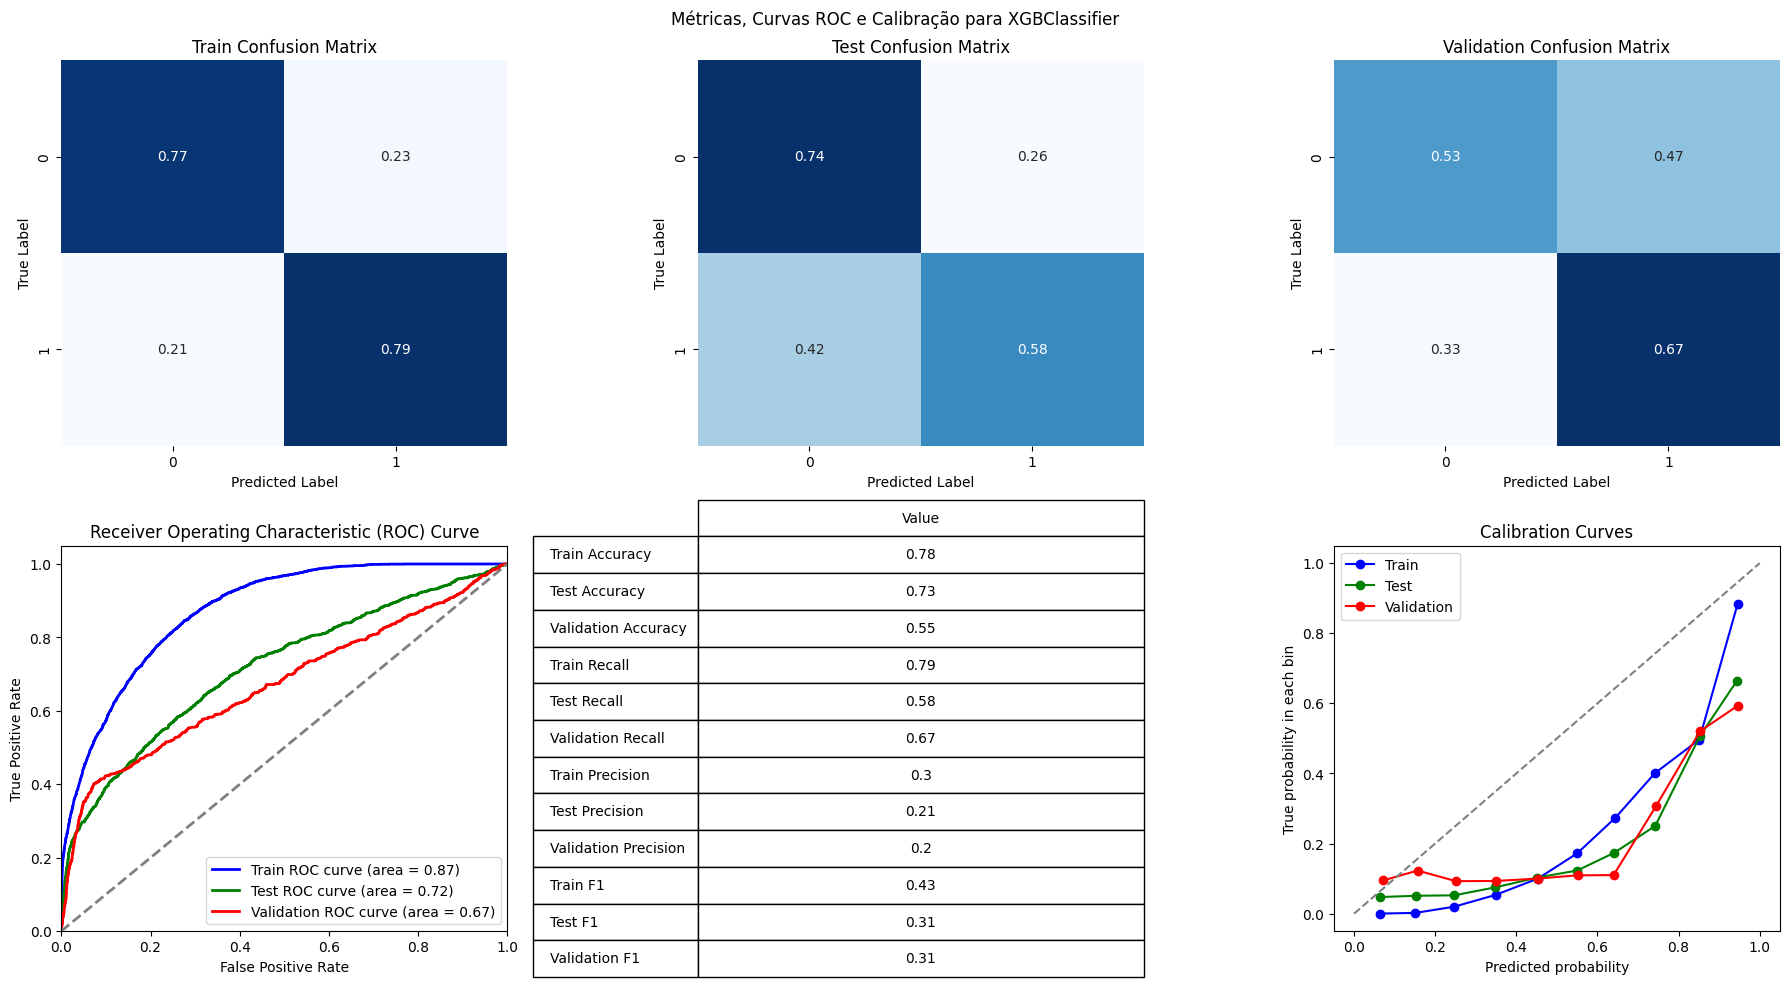

In [ ]:
X_train1a = X_train1.drop(columns=['contact_telephone', 'previous', 'housing', 'poutcome_failure', 'job_admin.'])
X_test1a = X_test1.drop(columns=['contact_telephone', 'previous', 'housing', 'poutcome_failure', 'job_admin.'])
X_val1a = X_val1.drop(columns=['contact_telephone', 'previous', 'housing', 'poutcome_failure', 'job_admin.'])

model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09, **best_params)
plot_confusion_matrix_and_roc(model, X_train1a, y_train, X_test1a, y_test, X_val1a, y_val)

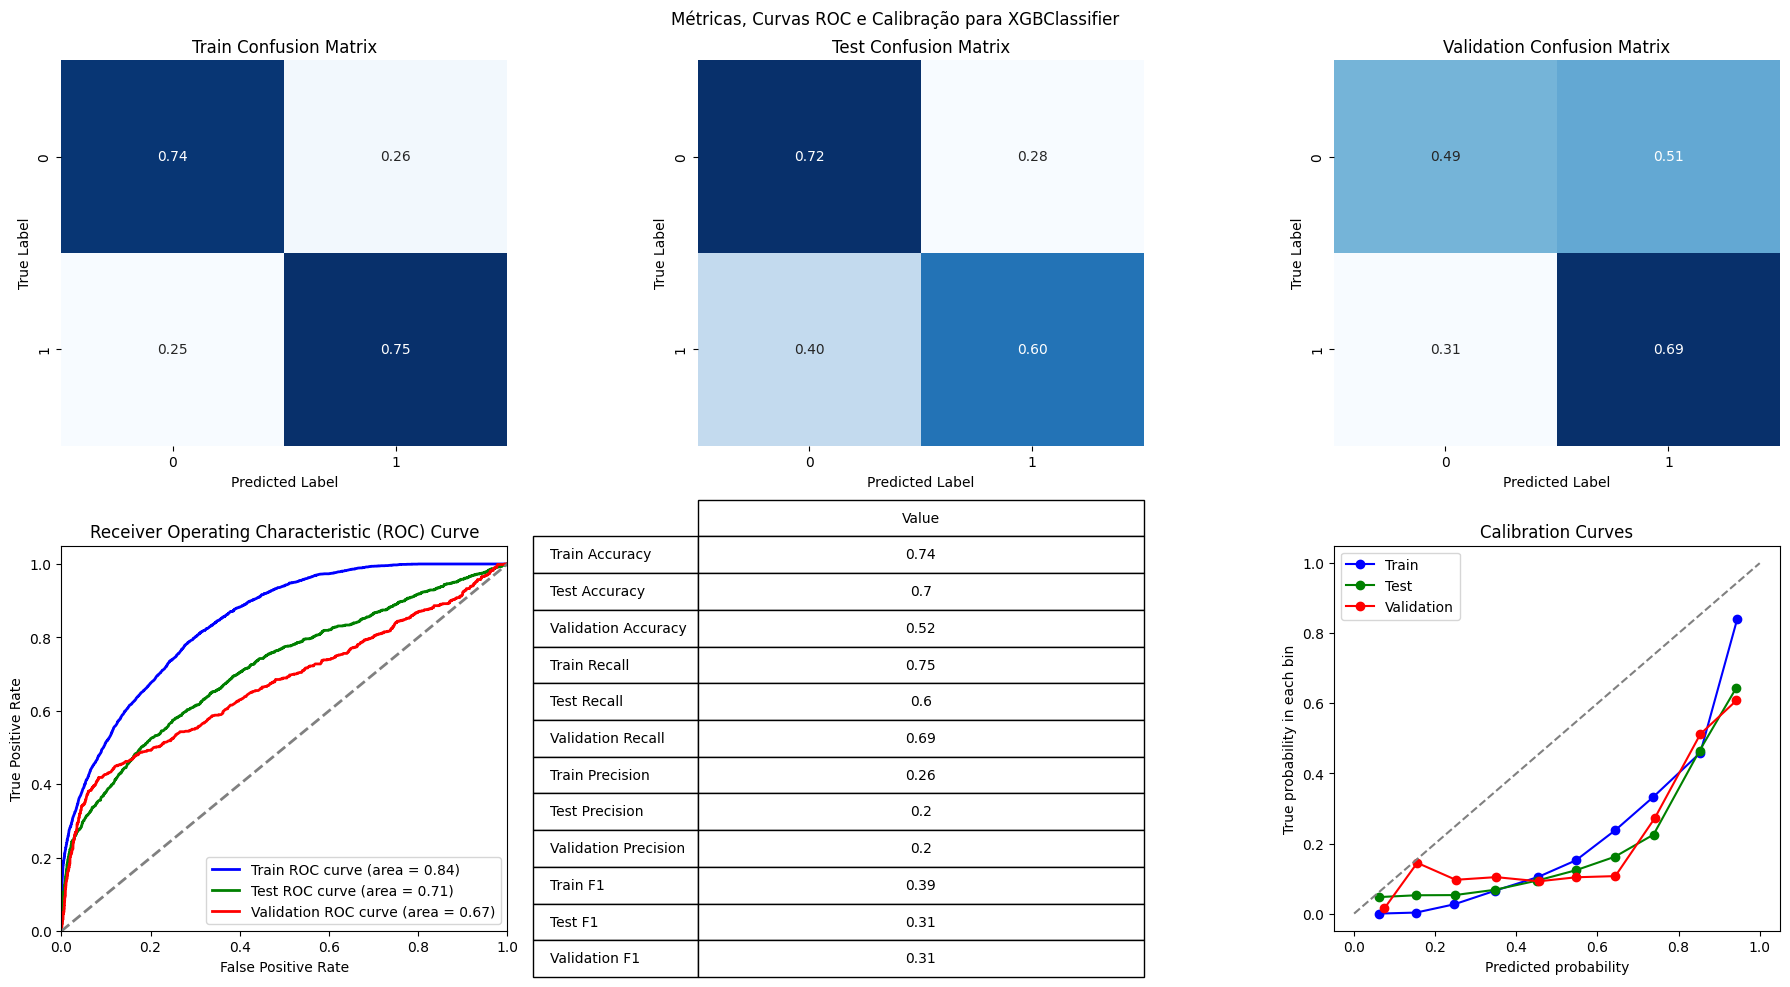

In [ ]:
X_train1a = X_train1.drop(columns=['contact_telephone', 'previous', 'housing', 'poutcome_failure', 'job_admin.', 'marital_married', 'loan', 'education', 'job_retired', 'job_technician'])
X_test1a = X_test1.drop(columns=['contact_telephone', 'previous', 'housing', 'poutcome_failure', 'job_admin.', 'marital_married', 'loan', 'education', 'job_retired', 'job_technician'])
X_val1a = X_val1.drop(columns=['contact_telephone', 'previous', 'housing', 'poutcome_failure', 'job_admin.', 'marital_married', 'loan', 'education', 'job_retired', 'job_technician'])

model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09, **best_params)
plot_confusion_matrix_and_roc(model, X_train1a, y_train, X_test1a, y_test, X_val1a, y_val)

De forma geral, os resultados pioraram ao removermos algumas features menos importantes, afetando especialmente a predição correta dos clientes que converteriam, resultando em mais falsos positivos.

As variáveis mais importantes confirmam o que foi analisado anteriormente no Data Understanding: a melhor predição para conversão é a participação e conversão em campanhas anteriores.

Uma maneira de melhorar a predição de conversão é segmentar o público-alvo. Isso pode ser feito de forma supervisionada, utilizando regras de negócio e análise exploratória, ou de forma não supervisionada, com algoritmos de segmentação.

### 6.2 SEGMENTAÇÃO POR REGRAS DE NEGÓCIO: LEADS VS CLIENTES

Iremos segmentar o público com base em regras de negócio, focando na participação em campanhas anteriores, para melhorar a precisão sem aumentar a complexidade do problema.

Isso alinha-se com nossas descobertas de que histórico de participação é um forte indicador de conversão. Para fins de teste, utilizaremos o algoritmo selecionado anteriormente, sem otimização, a fim de validar a eficácia dessa segmentação de maneira prática e eficiente.

#### 6.2.1 MODELO CLIENTES

##### 6.2.1.1 TREINAMENTO

In [116]:
indep_columns1 = ['age','education',
'default',
'housing',
'loan',
'campaign',
'pdays',
'previous',
'job_admin.',
'job_blue-collar',
'job_entrepreneur',
'job_housemaid',
'job_management',
'job_retired',
'job_self-employed',
'job_services',
'job_student',
'job_technician',
'job_unemployed',
'marital_divorced',
'marital_married',
'marital_single',
'contact_cellular',
'contact_telephone']

In [117]:
df_train1 = df_train[(df_train['poutcome_success'] == True) | (df_train['poutcome_failure'] == True)]
df_test1 = df_test[(df_test['poutcome_success'] == True) | (df_test['poutcome_failure'] == True)]
df_val1 = df_val[(df_val['poutcome_success'] == True) | (df_val['poutcome_failure'] == True)]

In [118]:
X_traincli = df_train1[indep_columns1]
X_testcli = df_test1[indep_columns1]
X_valcli = df_val1[indep_columns1]

y_train = df_train1[dep_column]
y_test = df_test1[dep_column]
y_val = df_val1[dep_column]

In [44]:
freq_table_train = create_freq_table(df_train1)
freq_table_test = create_freq_table(df_test1)
freq_table_val = create_freq_table(df_val1)

combined_freq_table = pd.merge(freq_table_train, freq_table_test, on='Resposta', how='outer', suffixes=('_Train', '_Test'))
combined_freq_table = pd.merge(combined_freq_table, freq_table_val, on='Resposta', how='outer')
combined_freq_table = combined_freq_table.rename(columns={'Contagem': 'Contagem_Val', 'Percentual': 'Percentual_Val'})

display(combined_freq_table)

Resposta  Contagem_Train  Percentual_Train  Contagem_Test  Percentual_Test  \
0         0            2171             72.41            967            73.31   
1         1             827             27.59            352            26.69   

   Contagem_Val  Percentual_Val  
0           988           75.54  
1           320           24.46

3.350665054413543


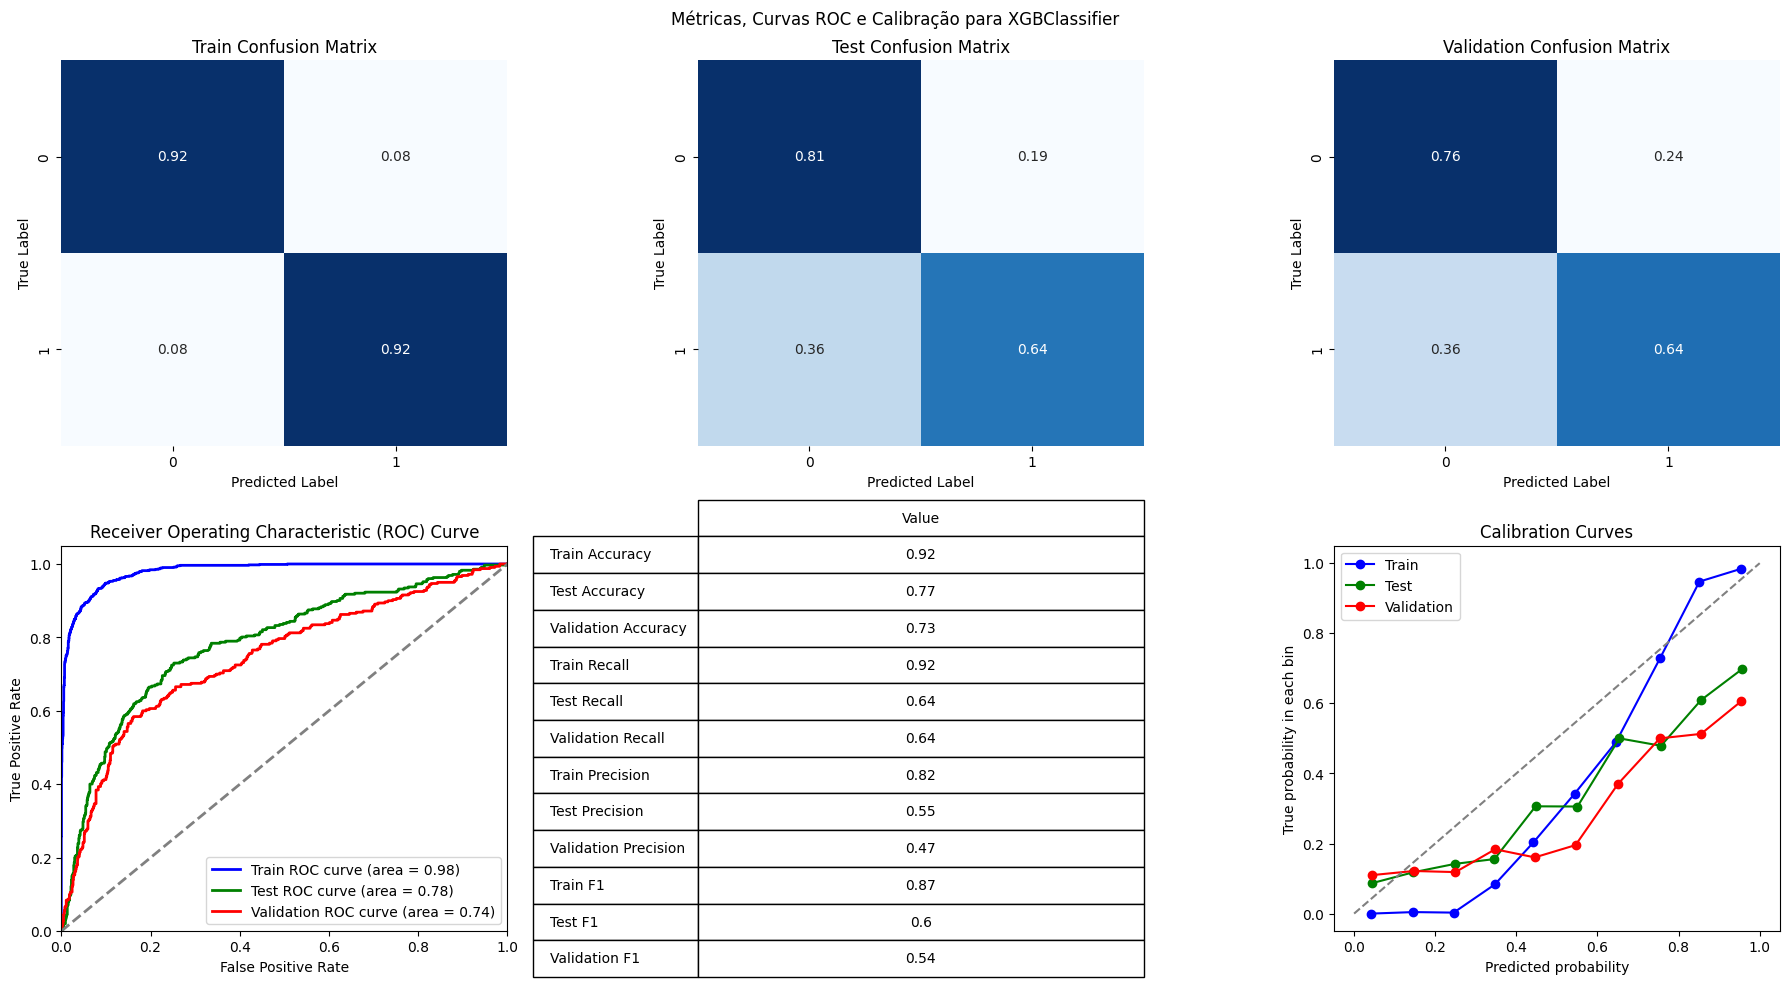

In [ ]:
scale_pos_weight = 2771/827
print(scale_pos_weight)
model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=scale_pos_weight)
plot_confusion_matrix_and_roc(model, X_traincli, y_train, X_testcli, y_test, X_valcli, y_val)

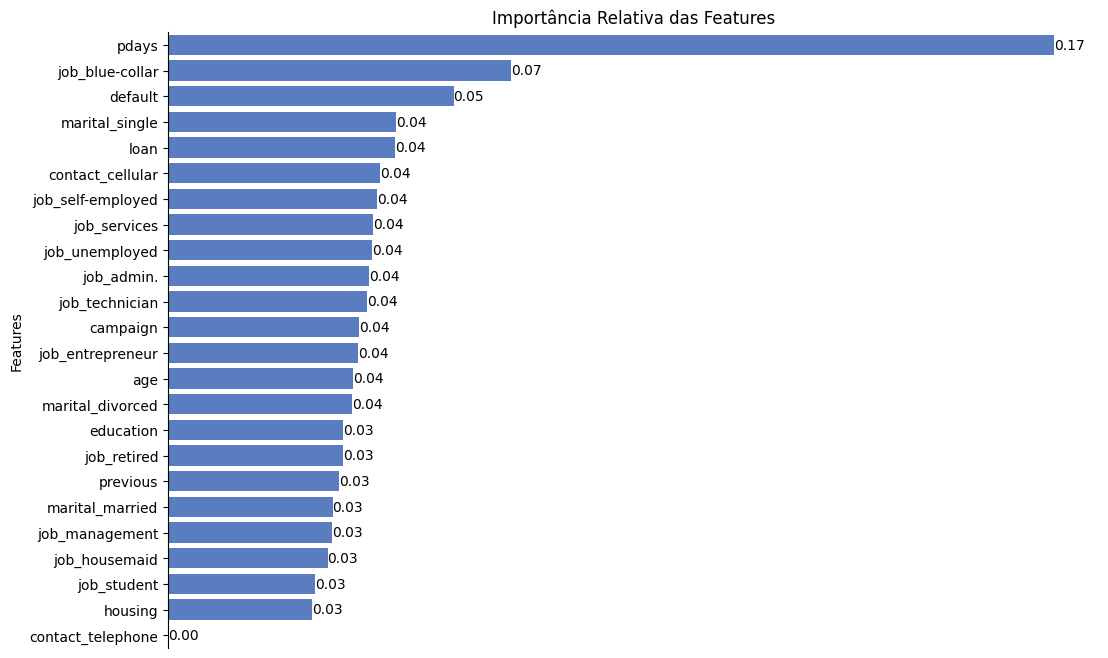

In [ ]:
feature_importances = model.feature_importances_
relative_importances = feature_importances / feature_importances.sum()

features = X_traincli.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': relative_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)

# Adicionando os valores dentro das barras
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.2f}', va='center')

plt.title('Importância Relativa das Features')
plt.xlabel('Importância Relativa')
plt.ylabel('Features')
plt.gca().get_xaxis().set_visible(False)
sns.despine(left=False, bottom=True)
plt.show()

##### 6.2.1.2 REMOÇÃO DE FEATURES

3.350665054413543


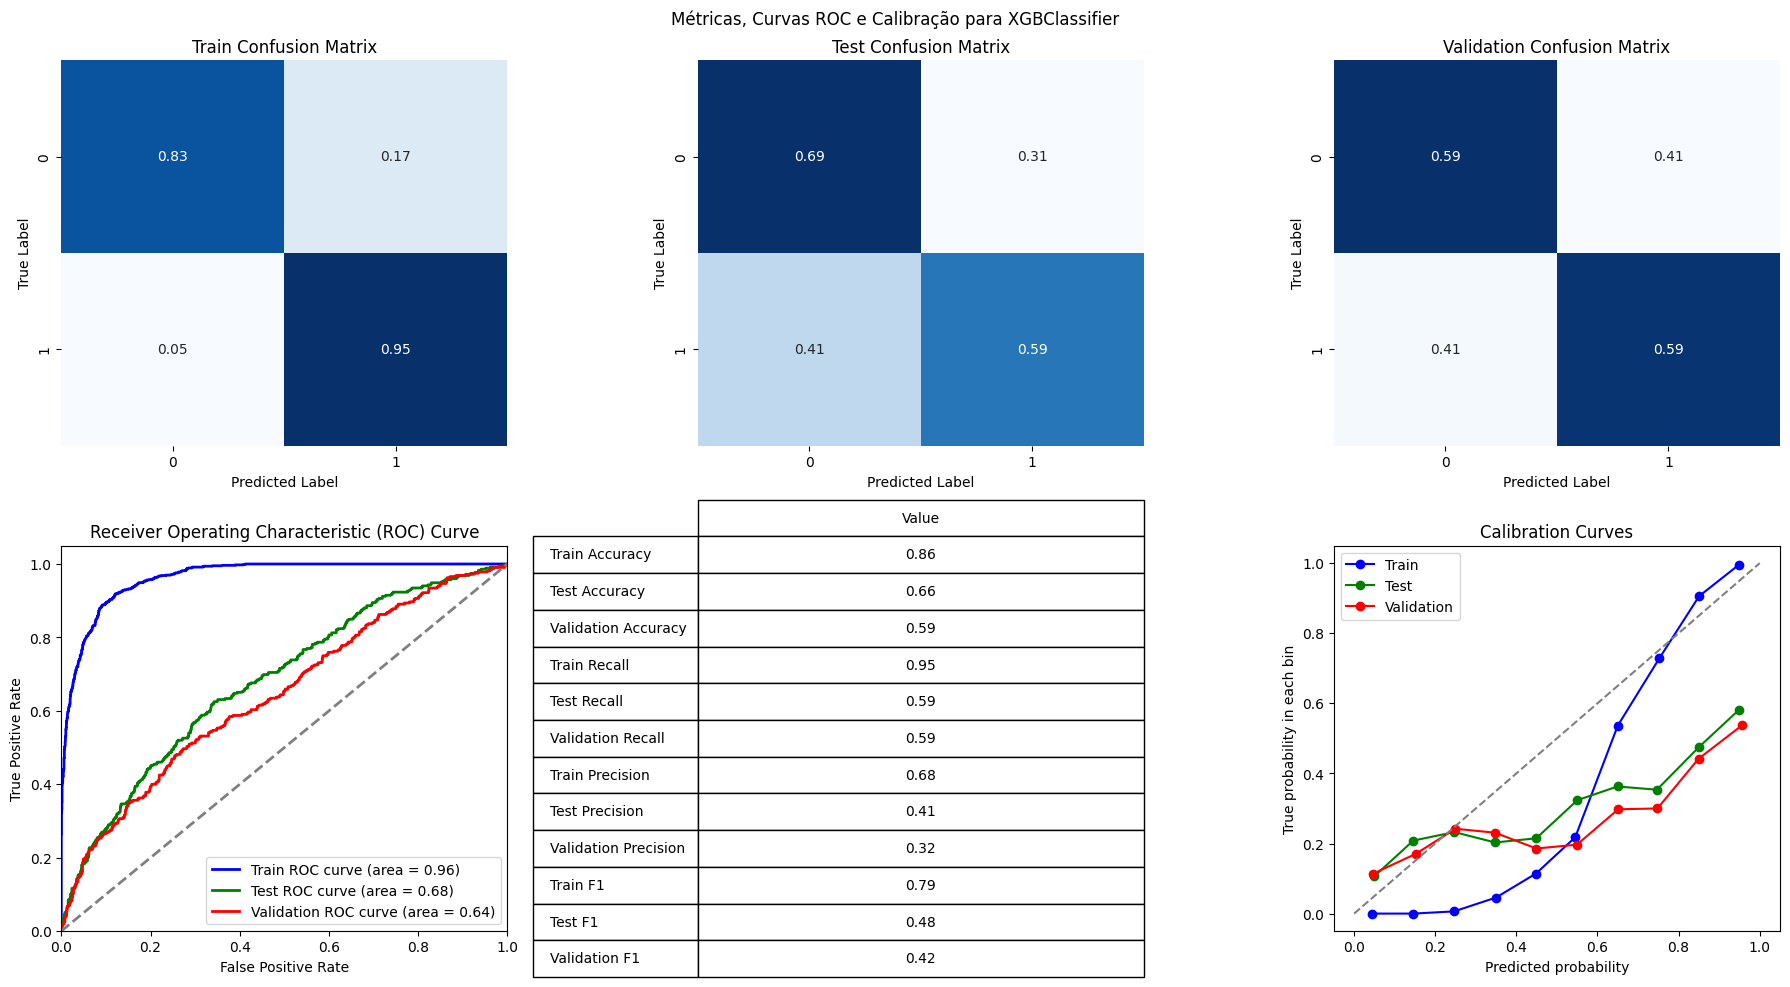

In [ ]:
#removendo variáveis
X_traincli = df_train1[indep_columns1].drop(columns=['contact_telephone', 'pdays'])
X_testcli = df_test1[indep_columns1].drop(columns=['contact_telephone', 'pdays'])
X_valcli = df_val1[indep_columns1].drop(columns=['contact_telephone', 'pdays'])

scale_pos_weight = 2771/827
print(scale_pos_weight)
model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=scale_pos_weight)
plot_confusion_matrix_and_roc(model, X_traincli, y_train, X_testcli, y_test, X_valcli, y_val)

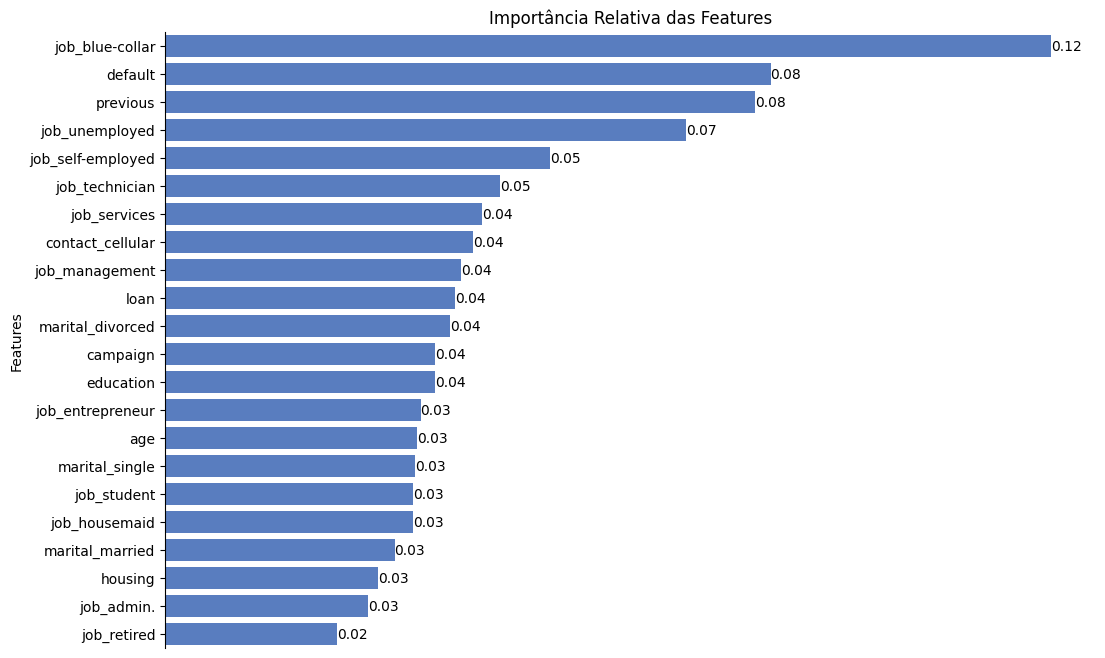

In [ ]:
feature_importances = model.feature_importances_
relative_importances = feature_importances / feature_importances.sum()

features = X_traincli.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': relative_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)

# Adicionando os valores dentro das barras
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.2f}', va='center')

plt.title('Importância Relativa das Features')
plt.xlabel('Importância Relativa')
plt.ylabel('Features')
plt.gca().get_xaxis().set_visible(False)
sns.despine(left=False, bottom=True)
plt.show()

##### 6.2.1.3 OTIMIZAÇÃO

In [119]:
X_traincli = df_train1[indep_columns1]
X_testcli = df_test1[indep_columns1]
X_valcli = df_val1[indep_columns1]

y_train = df_train1[dep_column]
y_test = df_test1[dep_column]
y_val = df_val1[dep_column]

In [ ]:
scale_pos_weight = 2771/827
print(scale_pos_weight)
xgb = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=scale_pos_weight)

#espaço de busca dos hiperparâmetros
param_distributions = {
    'n_estimators': np.arange(50, 201, 50),  # Variação do número de estimadores
    'learning_rate': np.linspace(0.01, 0.3, 10),  # Taxa de aprendizado
    'max_depth': np.arange(3, 11, 2),  # Profundidade máxima
    'min_child_weight': np.arange(1, 6, 2),
    'subsample': np.linspace(0.6, 1.0, 5),  # Subamostragem
    'colsample_bytree': np.linspace(0.6, 1.0, 5),  # Subamostragem de colunas por árvore
    'gamma': np.linspace(0, 0.5, 5)  # Parâmetro de regularização gamma

}


#otimizador de hiperparâmetros usando RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=300,
    scoring='f1',
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_traincli, y_train)

best_params = random_search.best_params_
print(f'Melhores hiperparâmetros: {best_params}')

best_model = random_search.best_estimator_

y_test_pred = best_model.predict_proba(X_testcli)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred)
print(f'ROC AUC no conjunto de teste: {test_auc}')

y_val_pred = best_model.predict_proba(X_valcli)[:, 1]
val_auc = roc_auc_score(y_val, y_val_pred)
print(f'ROC AUC no conjunto de validação: {val_auc}')

3.350665054413543
Fitting 3 folds for each of 300 candidates, totalling 900 fits
Melhores hiperparâmetros: {'subsample': 0.6, 'n_estimators': 50, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.042222222222222223, 'gamma': 0.125, 'colsample_bytree': 1.0}
ROC AUC no conjunto de teste: 0.8367623037510576
ROC AUC no conjunto de validação: 0.8199028972672066


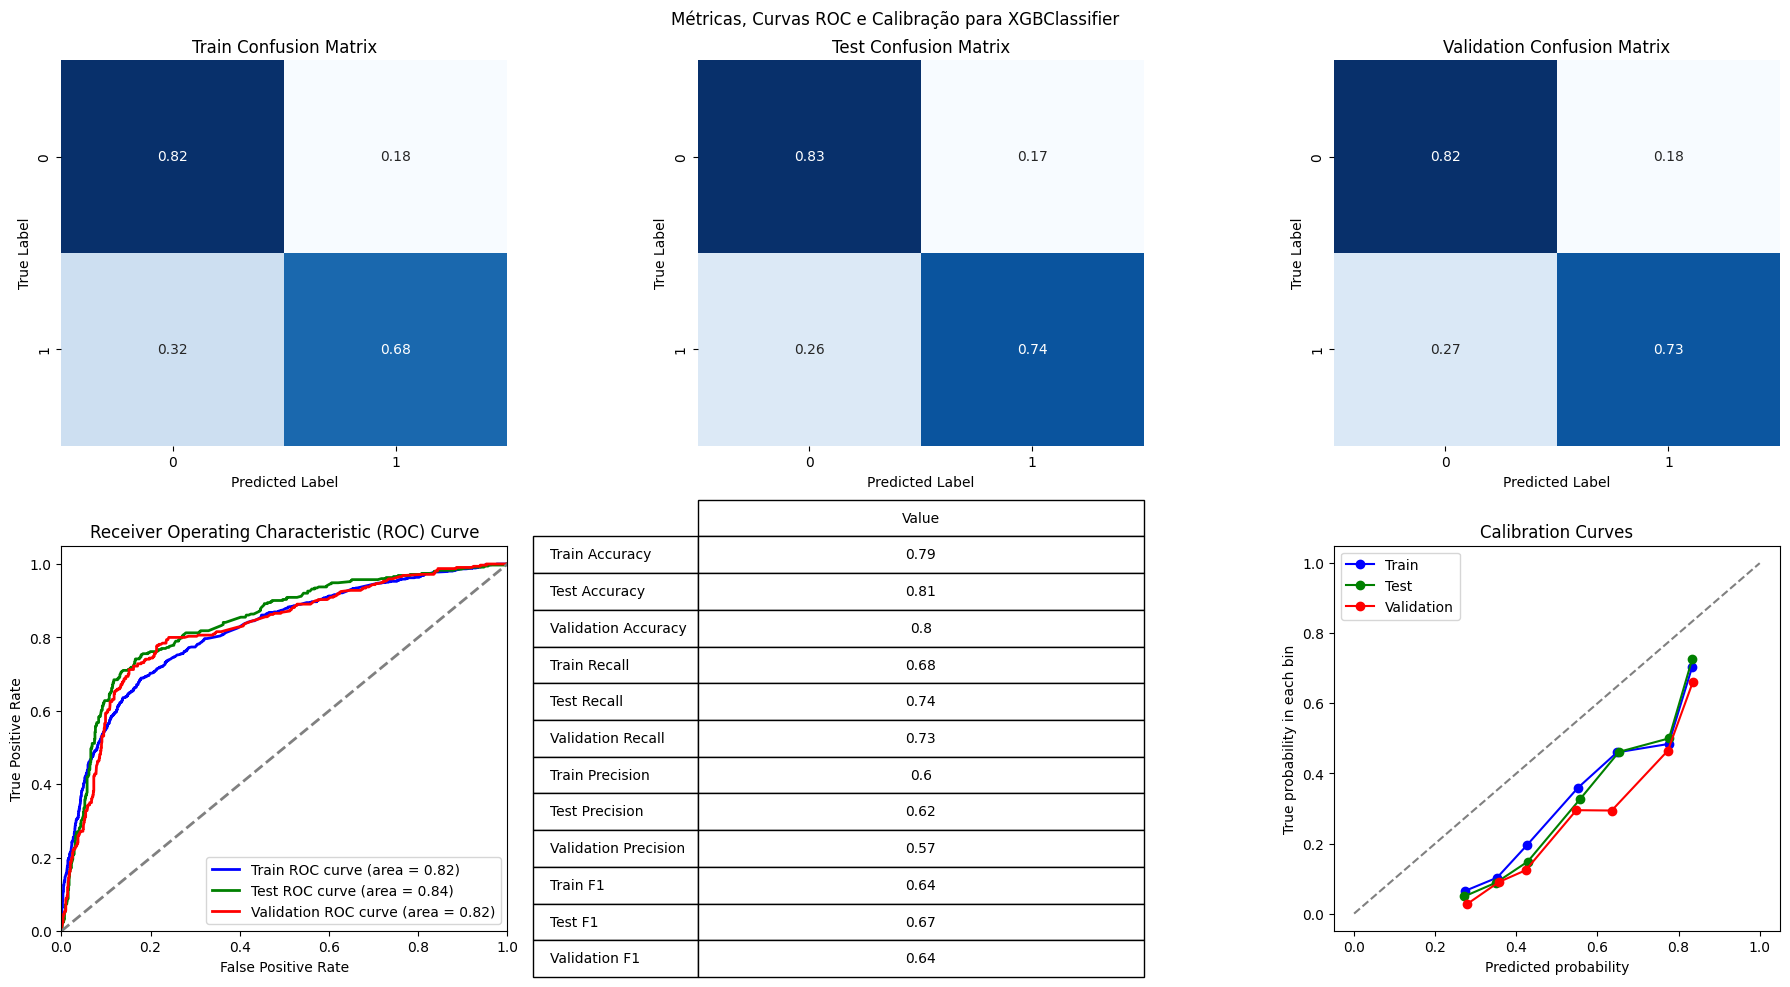

In [120]:
scale_pos_weight = 2771/827
best_params = {'subsample': 0.6, 'n_estimators': 50, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.042222222222222223, 'gamma': 0.125, 'colsample_bytree': 1.0}
model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=scale_pos_weight, **best_params)
plot_confusion_matrix_and_roc(model, X_traincli, y_train, X_testcli, y_test, X_valcli, y_val)

##### 6.2.1.4 CALIBRAÇÃO DE THRESHOLD

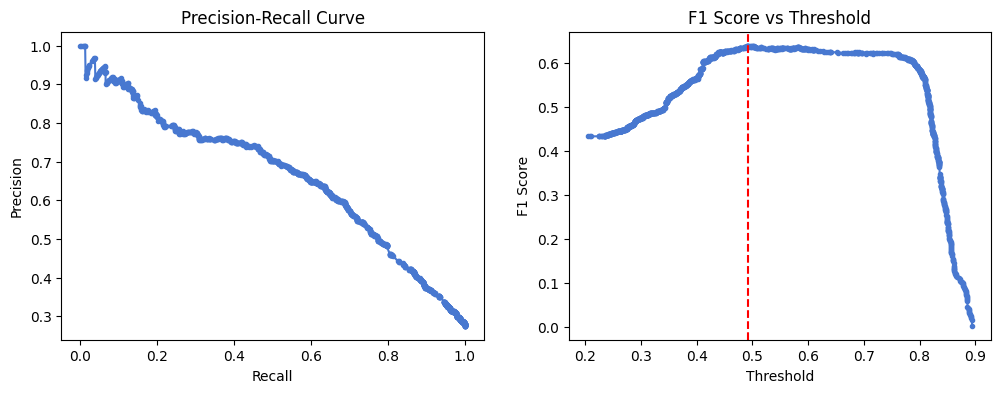

In [121]:
find_best_threshold(model, X_traincli, y_train)

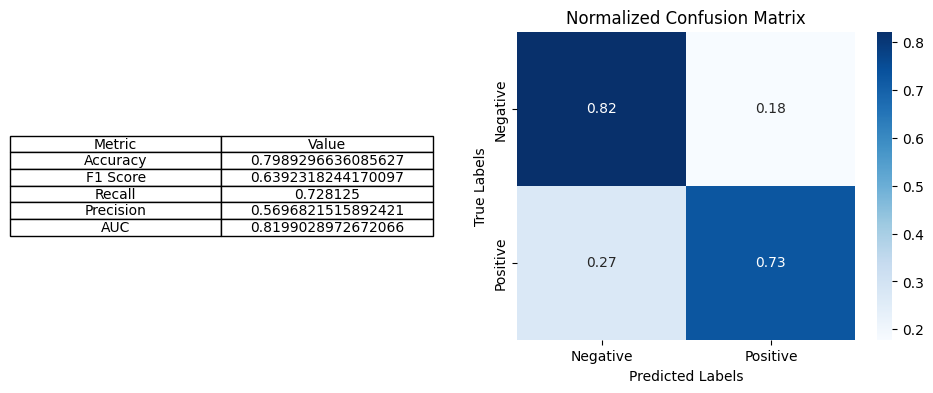

Os resultados foram calculados usando um threshold de: 0.5


In [136]:
plot_metrics_and_confusion_matrix(model, X_valcli, y_val, threshold=0.50)

#### 6.2.2 MODELO LEADS

##### 6.2.2.1 TREINAMENTO

In [48]:
indep_columns1 = ['age','education',
'default',
'housing',
'loan',
'campaign',
'previous',
'job_admin.',
'job_blue-collar',
'job_entrepreneur',
'job_housemaid',
'job_management',
'job_retired',
'job_self-employed',
'job_services',
'job_student',
'job_technician',
'job_unemployed',
'marital_divorced',
'marital_married',
'marital_single',
'contact_cellular',
'contact_telephone'
                  ]

In [49]:
df_train1 = df_train[(df_train['poutcome_success'] == False) & (df_train['poutcome_failure'] == False)]
df_test1 = df_test[(df_test['poutcome_success'] == False) & (df_test['poutcome_failure'] == False)]
df_val1 = df_val[(df_val['poutcome_success'] == False) & (df_val['poutcome_failure'] == False)]

In [50]:
X_train1 = df_train1[indep_columns1]
X_test1 = df_test1[indep_columns1]
X_val1 = df_val1[indep_columns1]

y_train = df_train1[dep_column]
y_test = df_test1[dep_column]
y_val = df_val1[dep_column]

In [13]:
freq_table_train = create_freq_table(df_train1)
freq_table_test = create_freq_table(df_test1)
freq_table_val = create_freq_table(df_val1)

combined_freq_table = pd.merge(freq_table_train, freq_table_test, on='Resposta', how='outer', suffixes=('_Train', '_Test'))
combined_freq_table = pd.merge(combined_freq_table, freq_table_val, on='Resposta', how='outer')
combined_freq_table = combined_freq_table.rename(columns={'Contagem': 'Contagem_Val', 'Percentual': 'Percentual_Val'})

display(combined_freq_table)

Resposta  Contagem_Train  Percentual_Train  Contagem_Test  Percentual_Test  \
0         0           20551              91.5           8771            91.44   
1         1            1909               8.5            821             8.56   

   Contagem_Val  Percentual_Val  
0          3100           88.29  
1           411           11.71

10.765322158198009


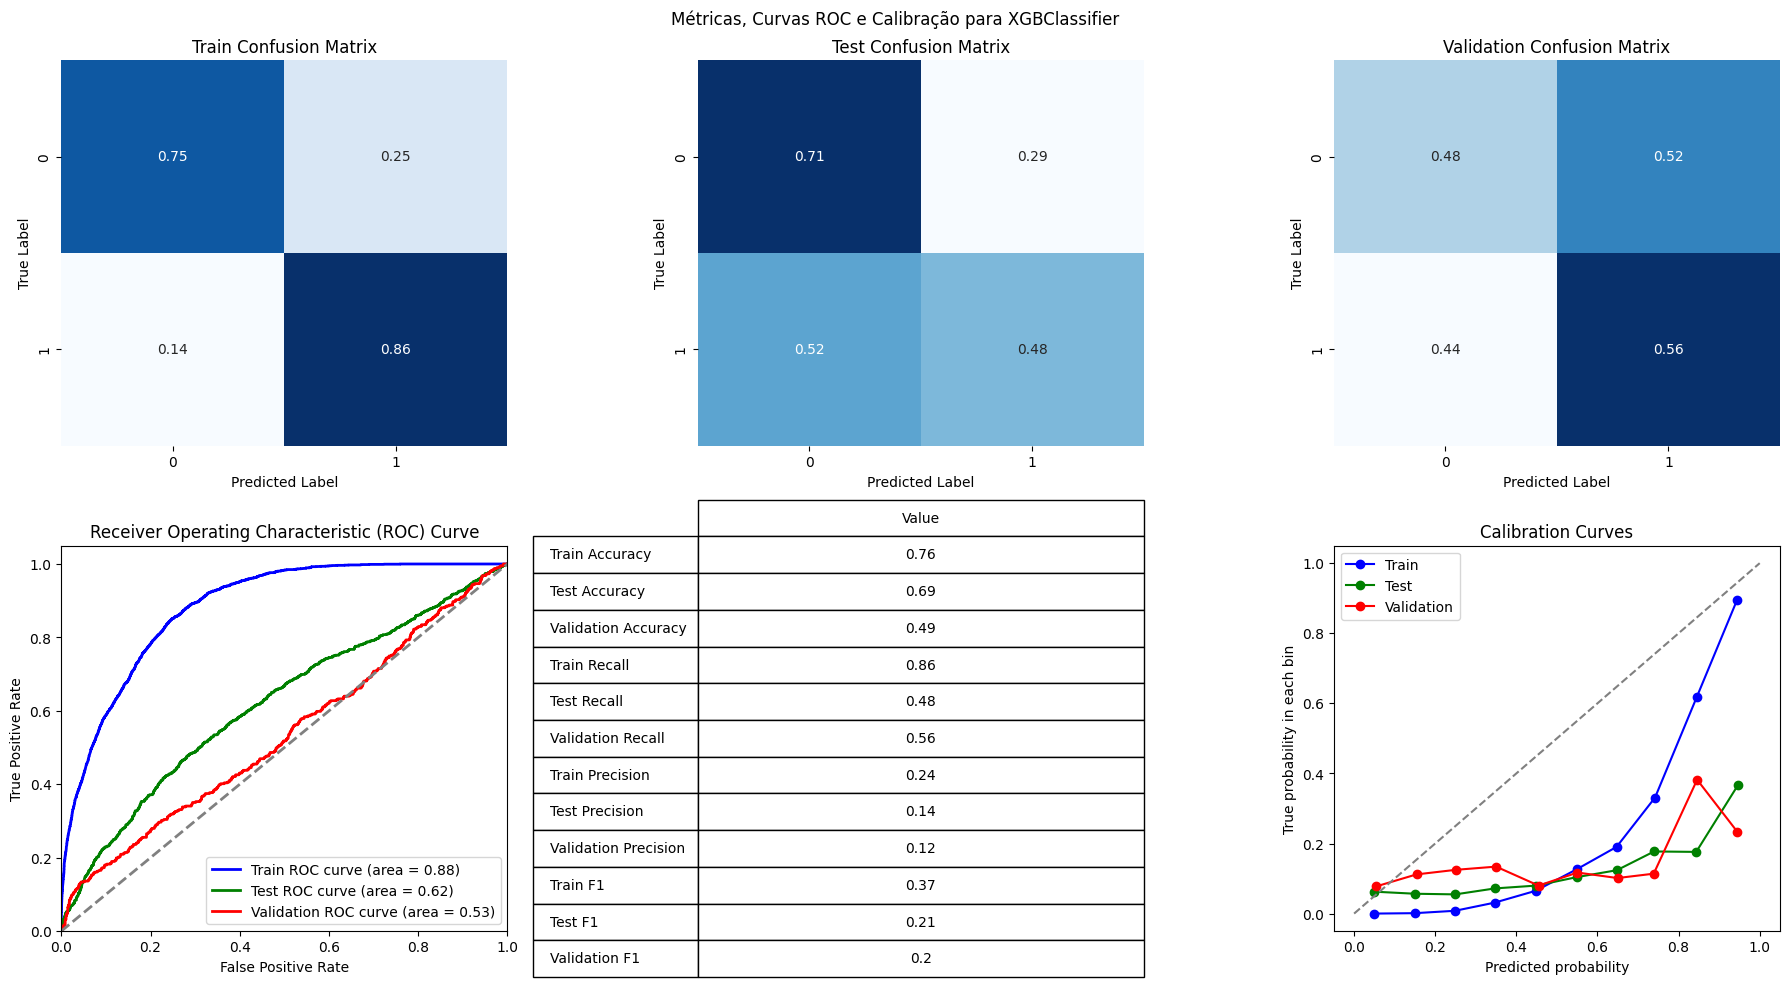

In [51]:
scale_pos_weight = 20551/1909
print(scale_pos_weight)
model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=scale_pos_weight)
plot_confusion_matrix_and_roc(model, X_train1, y_train, X_test1, y_test, X_val1, y_val)

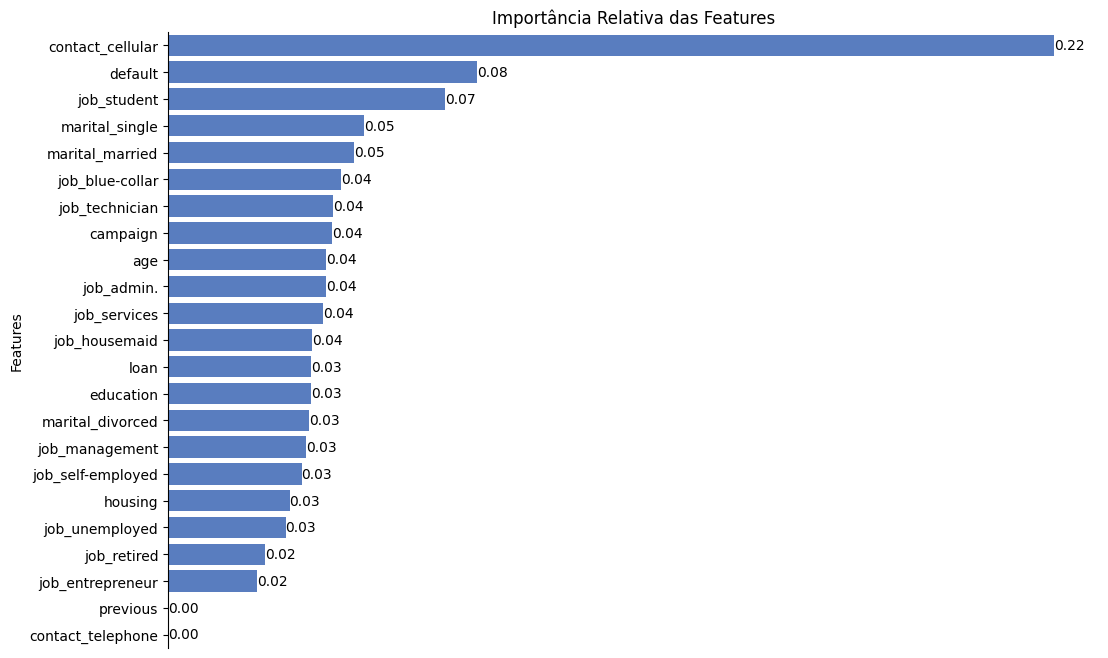

In [15]:
feature_importances = model.feature_importances_
relative_importances = feature_importances / feature_importances.sum()

features = X_train1.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': relative_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)

# Adicionando os valores dentro das barras
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.2f}', va='center')

plt.title('Importância Relativa das Features')
plt.xlabel('Importância Relativa')
plt.ylabel('Features')
plt.gca().get_xaxis().set_visible(False)
sns.despine(left=False, bottom=True)
plt.show()

##### 6.2.2.2 REMOÇÃO DE FEATURES

10.765322158198009


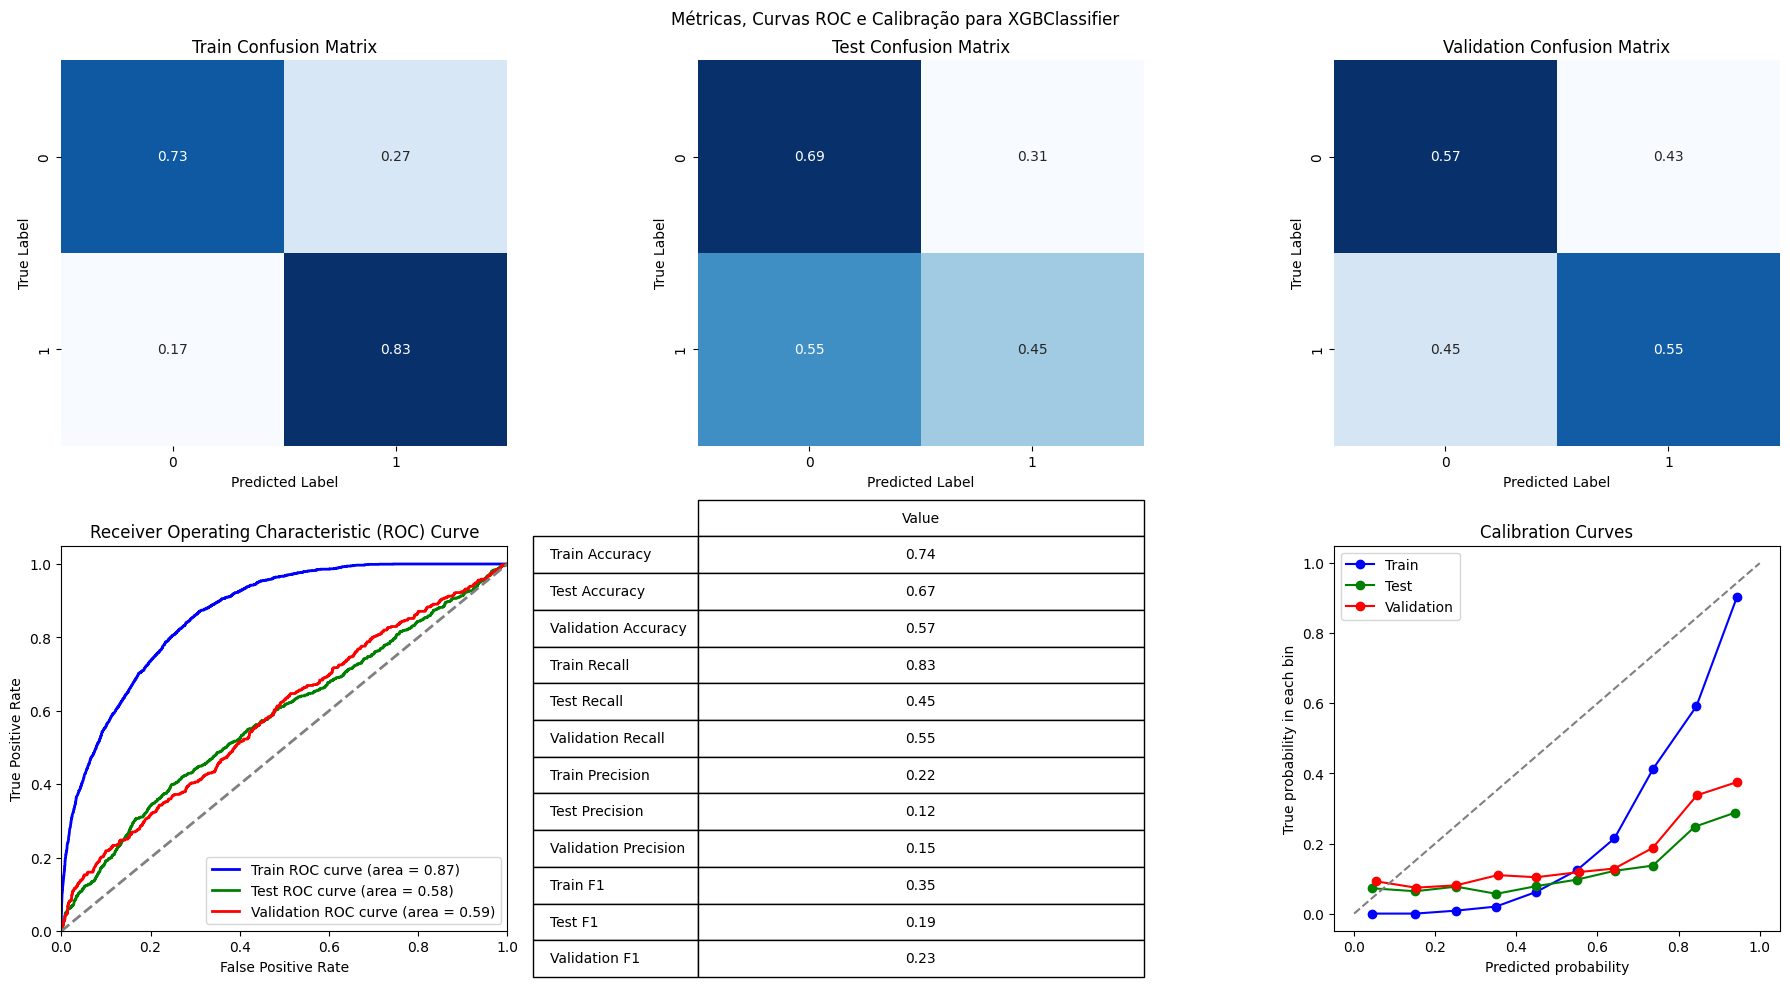

In [52]:
#removendo variáveis
X_train1 = df_train1[indep_columns1].drop(columns=['contact_telephone', 'previous', 'contact_cellular'])
X_test1 = df_test1[indep_columns1].drop(columns=['contact_telephone', 'previous', 'contact_cellular'])
X_val1 = df_val1[indep_columns1].drop(columns=['contact_telephone', 'previous', 'contact_cellular'])

scale_pos_weight = 20551/1909
print(scale_pos_weight)
model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=scale_pos_weight)
plot_confusion_matrix_and_roc(model, X_train1, y_train, X_test1, y_test, X_val1, y_val)

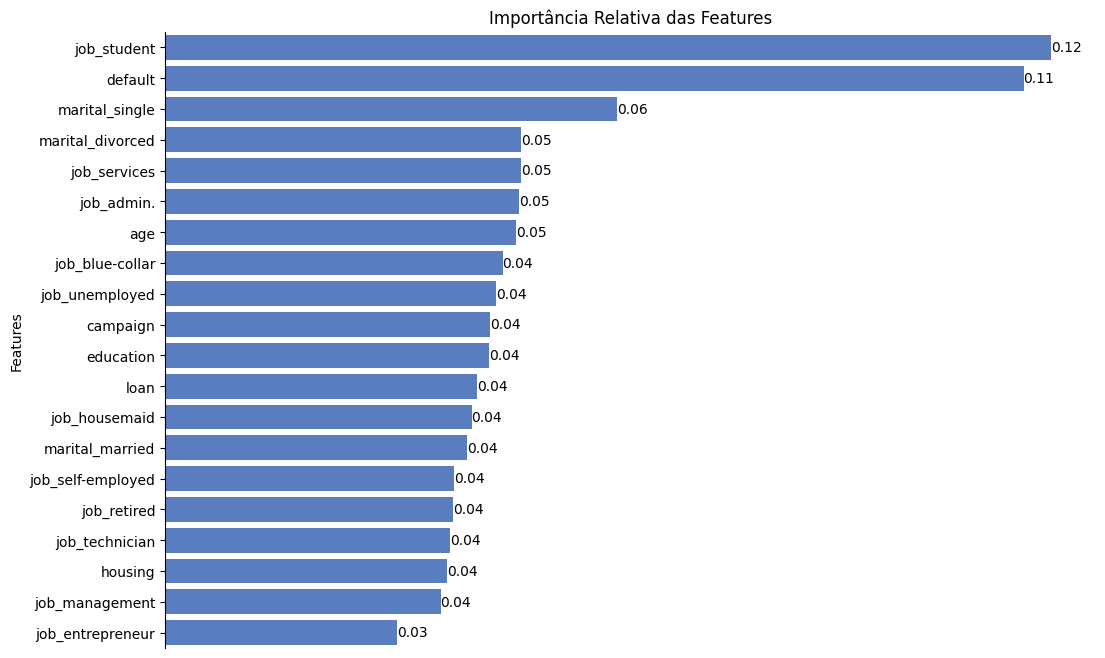

In [19]:
feature_importances = model.feature_importances_
relative_importances = feature_importances / feature_importances.sum()

features = X_train1.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': relative_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)

# Adicionando os valores dentro das barras
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.2f}', va='center')

plt.title('Importância Relativa das Features')
plt.xlabel('Importância Relativa')
plt.ylabel('Features')
plt.gca().get_xaxis().set_visible(False)
sns.despine(left=False, bottom=True)
plt.show()

##### 6.2.2.3 OTIMIZAÇÃO

In [20]:
scale_pos_weight = 20551/1909
print(scale_pos_weight)
xgb = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=scale_pos_weight)

#espaço de busca dos hiperparâmetros
param_distributions = {
    'n_estimators': np.arange(50, 201, 50),  # Variação do número de estimadores
    'learning_rate': np.linspace(0.01, 0.3, 10),  # Taxa de aprendizado
    'max_depth': np.arange(3, 11, 2),  # Profundidade máxima
    'min_child_weight': np.arange(1, 6, 2),
    'subsample': np.linspace(0.6, 1.0, 5),  # Subamostragem
    'colsample_bytree': np.linspace(0.6, 1.0, 5),  # Subamostragem de colunas por árvore
    'gamma': np.linspace(0, 0.5, 5)  # Parâmetro de regularização gamma

}


#otimizador de hiperparâmetros usando RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=300,
    scoring='f1',
    cv=3,
    verbose=50,
    random_state=41,
    n_jobs=-1
)

random_search.fit(X_train1, y_train)

best_params = random_search.best_params_
print(f'Melhores hiperparâmetros: {best_params}')

best_model = random_search.best_estimator_

y_test_pred = best_model.predict_proba(X_test1)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred)
print(f'ROC AUC no conjunto de teste: {test_auc}')

y_val_pred = best_model.predict_proba(X_val1)[:, 1]
val_auc = roc_auc_score(y_val, y_val_pred)
print(f'ROC AUC no conjunto de validação: {val_auc}')

10.765322158198009
Fitting 3 folds for each of 300 candidates, totalling 900 fits
Melhores hiperparâmetros: {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.0, 'colsample_bytree': 0.8}
ROC AUC no conjunto de teste: 0.62368998933619
ROC AUC no conjunto de validação: 0.6421399419197865


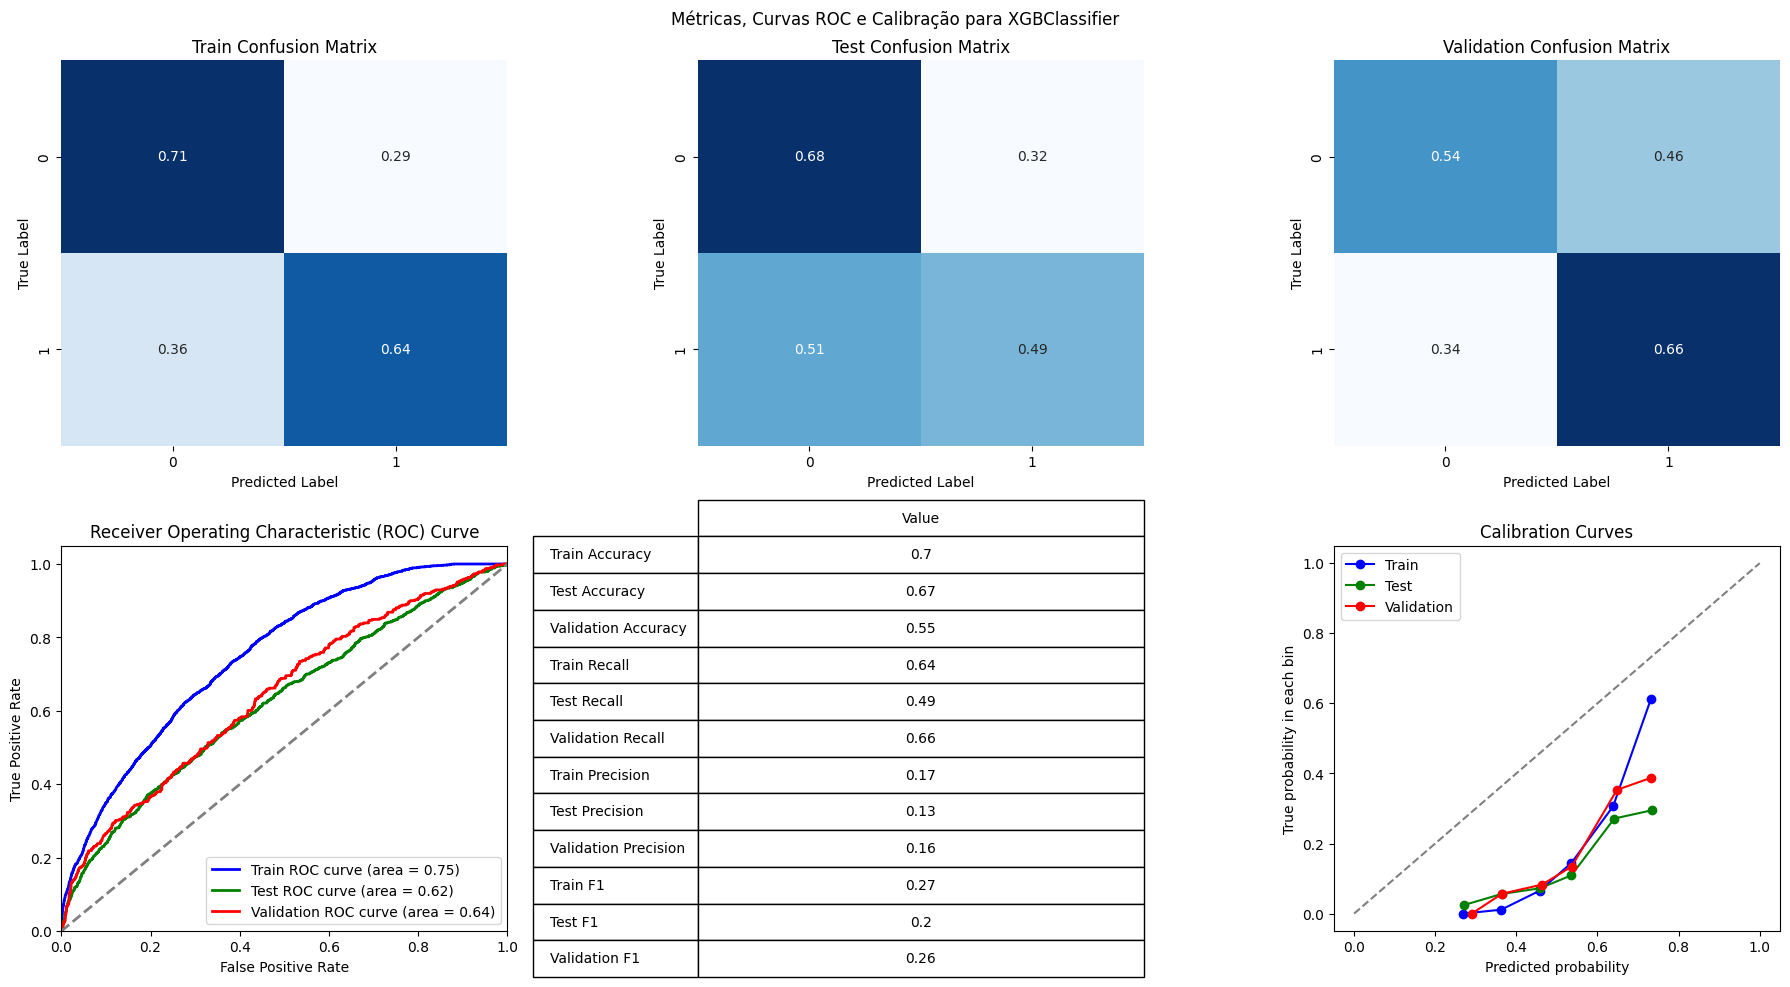

In [53]:
best_params = {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.0, 'colsample_bytree': 0.8}
model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=scale_pos_weight, **best_params)
plot_confusion_matrix_and_roc(model, X_train1, y_train, X_test1, y_test, X_val1, y_val)

##### 6.2.2.4 CALIBRAÇÃO DE THRESHOLD

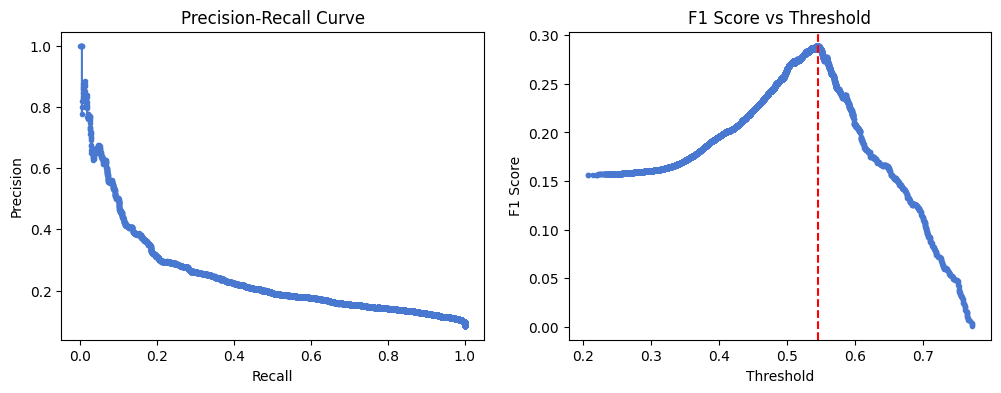

In [109]:
find_best_threshold(model, X_train1, y_train)

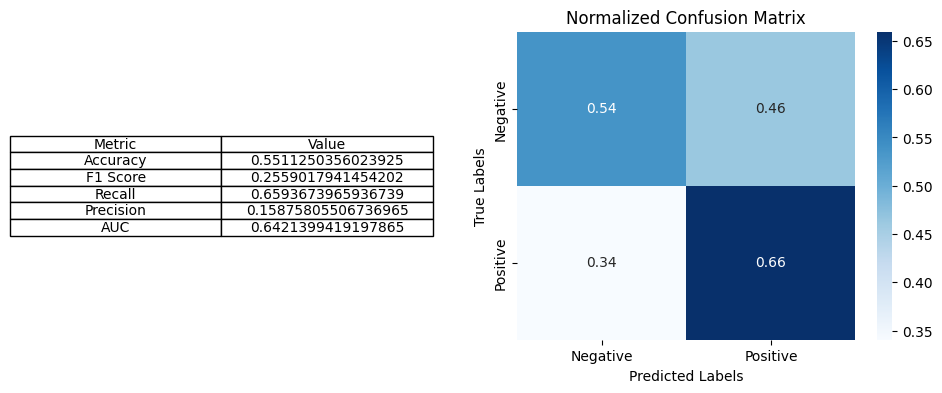

Os resultados foram calculados usando um threshold de: 0.5


In [114]:
plot_metrics_and_confusion_matrix(model, X_val1, y_val, threshold=0.5)

Como mencionado anteriormente, o modelo estava superestimando o público que já havia sido contactado anteriormente (clientes) e subestimando os que não haviam sido (leads).

Para abordar essa discrepância, dividimos o modelo em dois, um focado em clientes e outro em leads, seguido de uma rápida otimização. Com essa abordagem, conseguimos melhorar significativamente o desempenho em ambos os cenários, com um aumento de 16 pontos percentuais para clientes e 4 pontos percentuais para leads.

Após essa melhoria, tentamos calibrar a probabilidade da classe positiva. No entanto, os melhores resultados nos testes e na validação foram alcançados utilizando o threshold padrão de 50%.

Observamos que o problema se mostrou muito mais fácil de prever quando se tratava de clientes. Embora os resultados para leads tenham melhorado em relação aos iniciais, eles ainda são inferiores aos obtidos para clientes. Esse comportamento pode ser atribuído a características mais distintas e um histórico de dados mais rico no caso dos clientes, enquanto os leads possuem variabilidade maior e menos informações disponíveis para a modelagem precisa.

**Modelo de Clientes**: O desempenho consistente e robusto do modelo de clientes, com alta acurácia e recall, sugere que ele pode ser confiável para identificar clientes que provavelmente responderão positivamente às campanhas. Isso pode ajudar a melhorar a eficiência das estratégias de marketing e a alocação de recursos.

**Modelo de Leads**: O desempenho inferior do modelo de leads, especialmente na precisão e na F1 score, indica desafios na previsão de novos clientes potenciais. Apesar das melhorias, o modelo ainda luta para ser preciso e bem calibrado. Estratégias adicionais, como enriquecimento de dados ou ajustes de modelo usando uma segmentação, podem ser necessárias para aumentar a eficácia em identificar leads valiosos.